In [338]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
#from helpers import cluster_acc
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import adjusted_rand_score as ars
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from collections import Counter
from sklearn.metrics import accuracy_score as acc
import time
from time import clock
import os
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
import matplotlib as mpl
mpl.rcdefaults()
import warnings
warnings.filterwarnings("ignore")

## Data read/helpers

In [602]:
df1 = pd.read_csv("/Users/jayanth.mettu/repos/pers/gatech/ml/datasets/spambase.data", delimiter=",", header=None)
#df1 = shuffle(df1)
Y = df1.iloc[:, -1]
X = df1.iloc[:, :-1]
X_train, Y_train = X, Y
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)


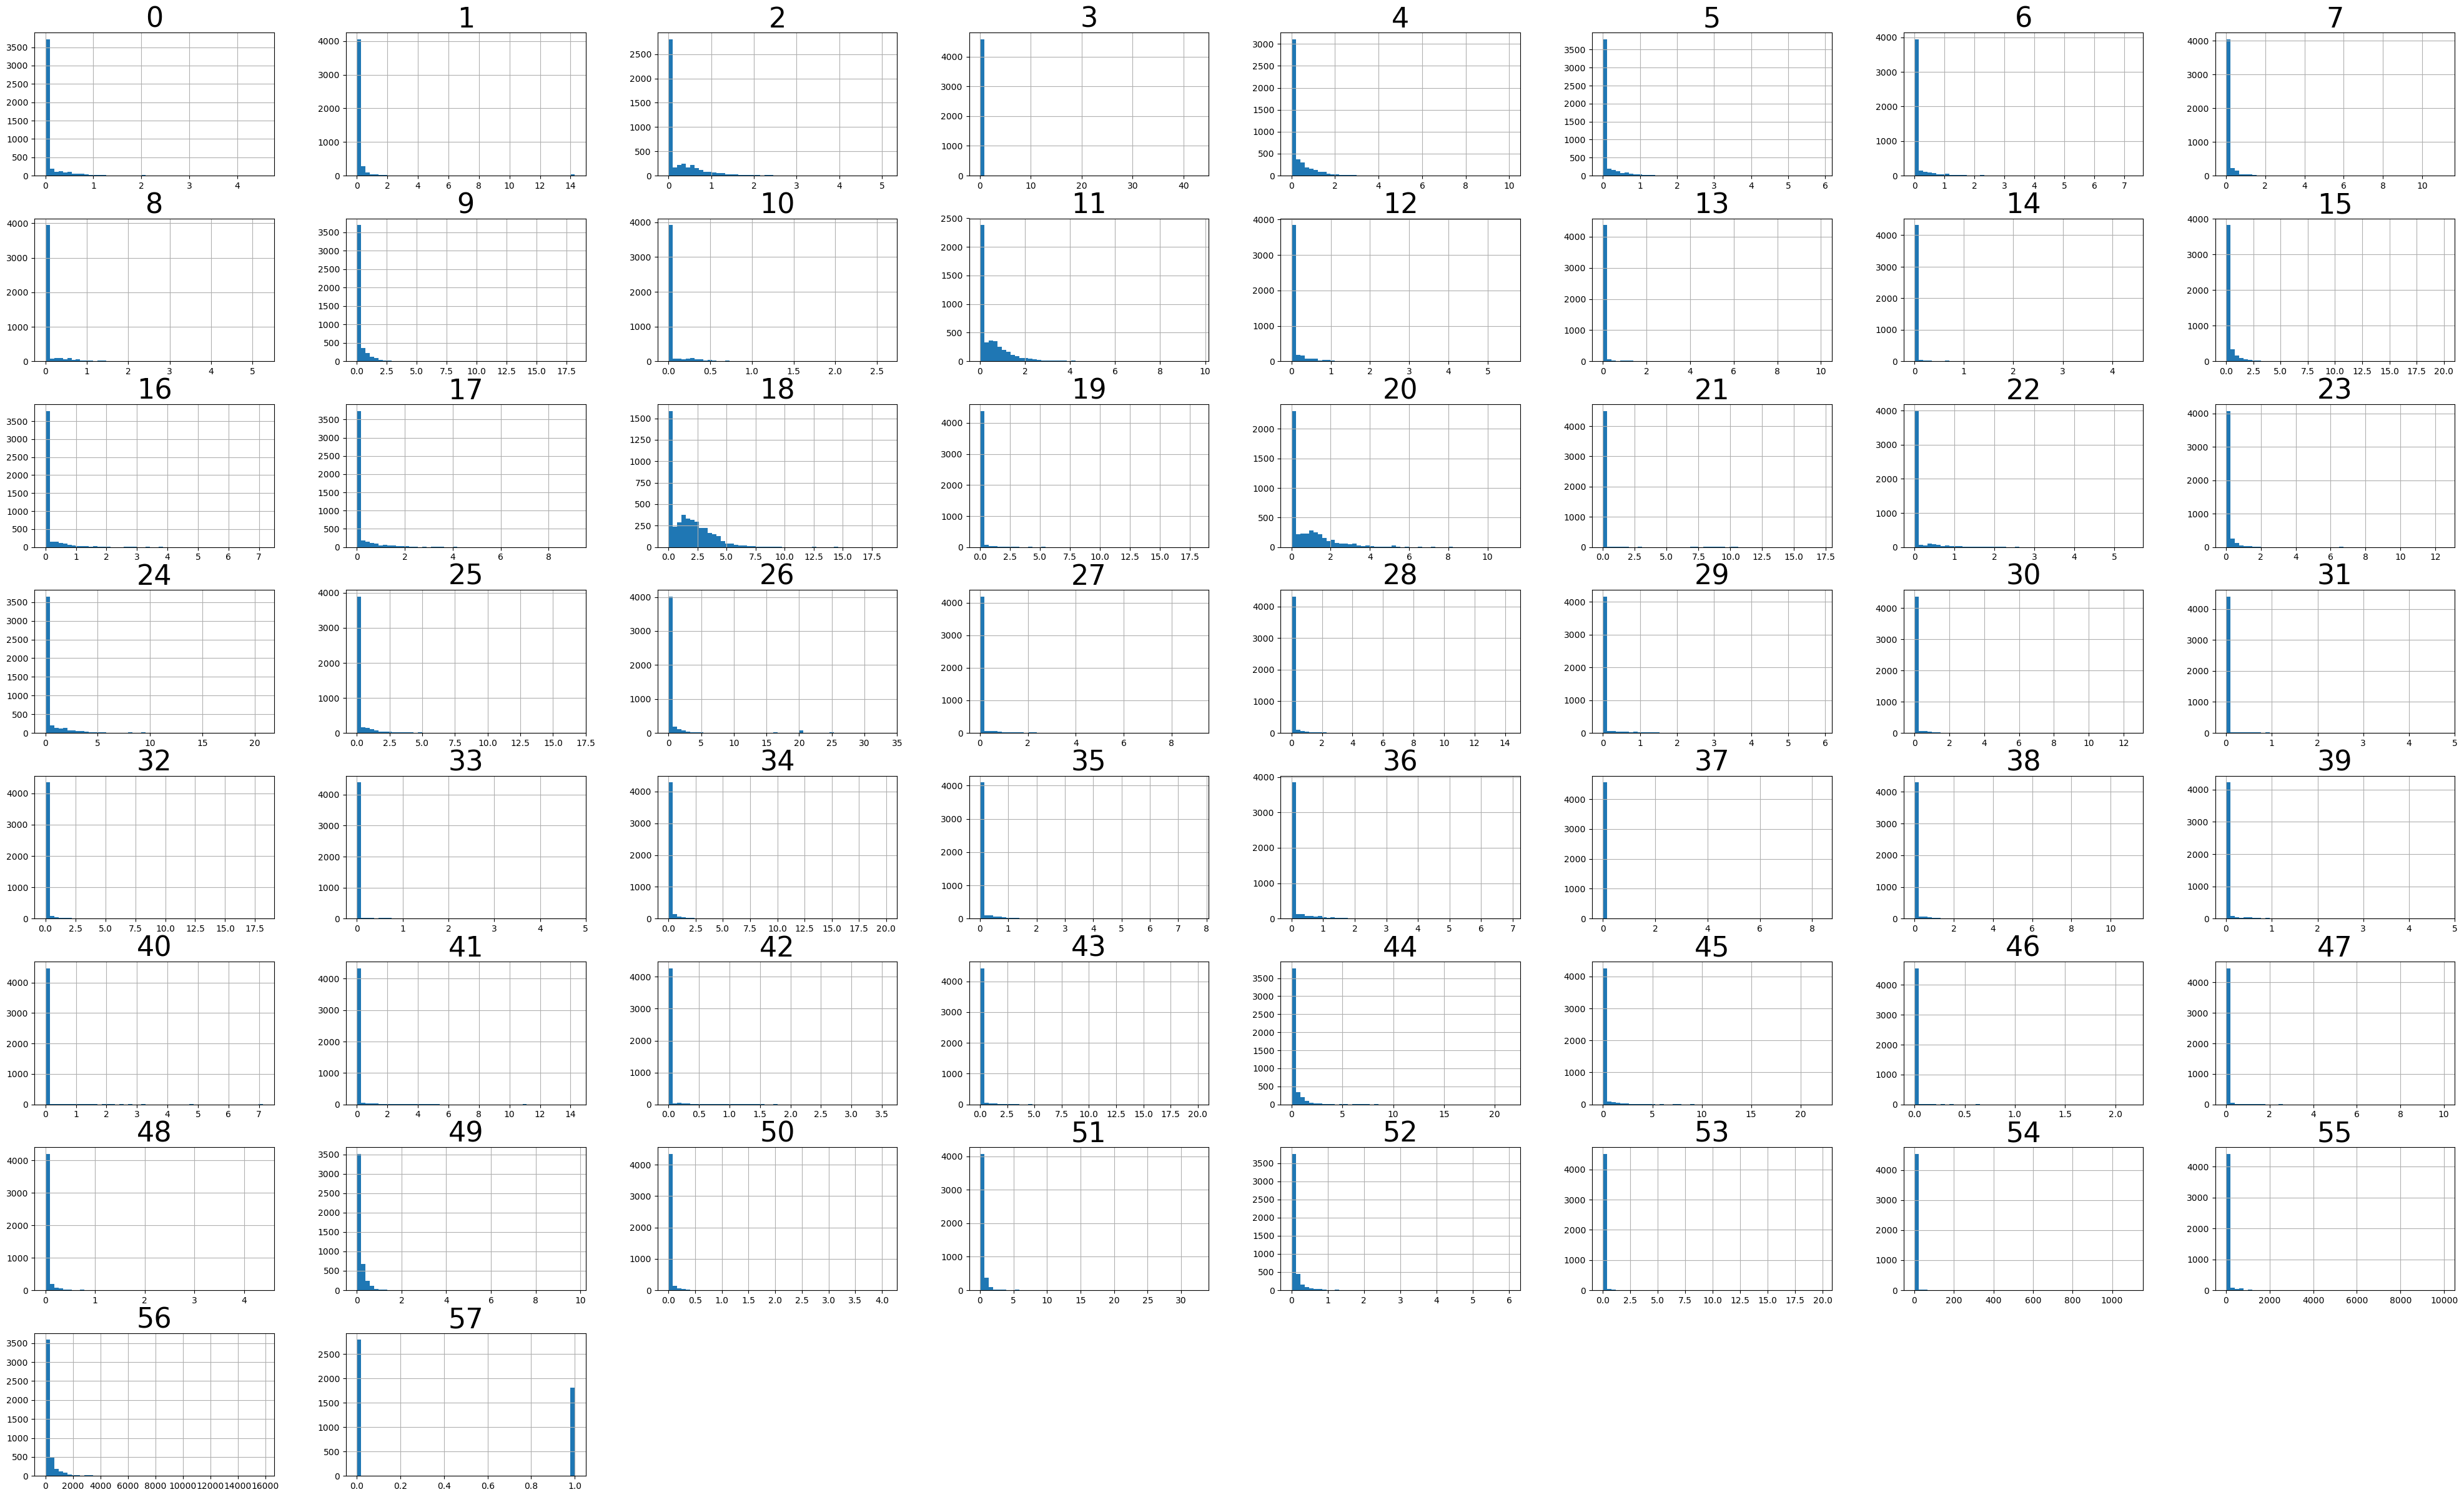

In [603]:
fig = df1.hist(figsize=(50, 30), bins=50)
[x.title.set_size(32) for x in fig.ravel()]
plt.show()

In [18]:
df1 = pd.read_csv("/Users/jayanth.mettu/repos/pers/gatech/ml/datasets/winequality-white.csv", delimiter=";")
df1 = shuffle(df1)
Y = pd.cut(df1['quality'],(2,5,6,10),labels=['low','medium', 'high'])
X = df1.iloc[:, :-1]
X2_train, Y2_train = X, Y
sc = StandardScaler()
X2_train = sc.fit_transform(X2_train)
X2_train = np.array(X2_train)
Y2_train = np.array(Y2_train)

X2_train_split, X2_test_split, Y2_train_split, Y2_test_split = train_test_split(X2_train, Y2_train, test_size=0.3, random_state=42)

In [19]:
def run_sse_ll(out, clusters, X_train, X2_train):
    SSE = defaultdict(dict)
    ll = defaultdict(dict)
    km = kmeans(random_state=5)
    gmm = GMM(random_state=5)

    st = clock()
    for k in clusters:
        km.set_params(n_clusters=k)
        gmm.set_params(n_components=k)
        km.fit(X_train)
        gmm.fit(X_train)
        SSE[k]['Spambase'] = km.score(X_train)
        ll[k]['Spambase'] = gmm.score(X_train)

        km.fit(X2_train)
        gmm.fit(X2_train)
        SSE[k]['Wine'] = km.score(X2_train)
        ll[k]['Wine'] = gmm.score(X2_train)
        print(k, clock() - st)

    SSE = (-pd.DataFrame(SSE)).T  
    SSE.rename(columns=lambda x: x + ' SSE (left)', inplace=True)
    ll = pd.DataFrame(ll).T
    ll.rename(columns=lambda x: x + ' log-likelihood', inplace=True)

    SSE.to_csv(out + 'SSE.csv')
    ll.to_csv(out + 'logliklihood.csv')


In [20]:
def run_clustering_metrics(out, k_spambase, k_wine, X_train, Y_train, X2_train, Y2_train):
    arsDict = defaultdict(lambda: defaultdict(dict))
    adjMI = defaultdict(lambda: defaultdict(dict))
    km = kmeans(random_state=5)
    gmm = GMM(random_state=5)

    km.set_params(n_clusters=k_spambase)
    gmm.set_params(n_components=k_spambase)
    km.fit(X_train)
    gmm.fit(X_train)
    arsDict[k_spambase]['Spambase']['Kmeans'] = ars(Y_train, km.predict(X_train))
    arsDict[k_spambase]['Spambase']['GMM'] = ars(Y_train, gmm.predict(X_train))
    adjMI[k_spambase]['Spambase']['Kmeans'] = ami(Y_train, km.predict(X_train))
    adjMI[k_spambase]['Spambase']['GMM'] = ami(Y_train, gmm.predict(X_train))

    km.set_params(n_clusters=k_wine)
    gmm.set_params(n_components=k_wine)
    km.fit(X2_train)
    gmm.fit(X2_train)
    arsDict[k_wine]['Wine']['Kmeans'] = ars(Y2_train, km.predict(X2_train))
    arsDict[k_wine]['Wine']['GMM'] = ars(Y2_train, gmm.predict(X2_train))
    adjMI[k_wine]['Wine']['Kmeans'] = ami(Y2_train, km.predict(X2_train))
    adjMI[k_wine]['Wine']['GMM'] = ami(Y2_train, gmm.predict(X2_train))

    arsDict = pd.Panel(arsDict)
    adjMI = pd.Panel(adjMI)
    arsDict.ix[:, :, 'Spambase'].to_csv(out + 'Spambase ars.csv')
    arsDict.ix[:, :, 'Wine'].to_csv(out + 'Wine ars.csv')
    adjMI.ix[:, :, 'Spambase'].to_csv(out + 'Spambase adjMI.csv')
    adjMI.ix[:, :, 'Wine'].to_csv(out + 'Wine adjMI.csv')    

In [556]:
def plot_clustering_metrics(out):
    
    # read data
    arsDict_wine = (pd.read_csv(out + "/Wine ars.csv",index_col=0,)).T
    arsDict_spambase = (pd.read_csv(out + "/Spambase ars.csv",index_col=0,)).T
    adjMI_wine = (pd.read_csv(out + "/Wine adjMI.csv",index_col=0,)).T
    adjMI_spambase = (pd.read_csv(out + "/Spambase adjMI.csv",index_col=0,)).T
    
    fig = plt.figure(figsize=(10,5)) 
    
    # create plot
    plt.subplot(1,2,1)
    n_groups = 2
    kmeans = (arsDict_spambase.loc['2']['Kmeans'], adjMI_spambase.loc['2']['Kmeans'])
    gmm = (arsDict_spambase.loc['2']['GMM'], adjMI_spambase.loc['2']['GMM'])

    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8
    plt.bar(index, kmeans, bar_width,alpha=opacity,color='b',label='Kmeans')
    rects2 = plt.bar(index + bar_width, gmm, bar_width,alpha=opacity,color='g',label='GMM') 
    plt.xlabel('Spambase')
    plt.ylabel('Scores')
    plt.title('Scores for Spambase')
    plt.xticks(index + bar_width, ('ARI', 'AMI'))
    plt.legend()

    # create plot
    plt.subplot(1,2,2)
    n_groups = 2
    kmeans = (arsDict_wine.loc['3']['Kmeans'], adjMI_wine.loc['3']['Kmeans'])
    gmm = (arsDict_wine.loc['3']['GMM'], adjMI_wine.loc['3']['GMM'])
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8
    plt.bar(index, kmeans, bar_width,alpha=opacity,color='b',label='Kmeans')
    rects2 = plt.bar(index + bar_width, gmm, bar_width,alpha=opacity,color='g',label='GMM') 
    plt.xlabel('Wine')
    plt.ylabel('Scores')
    plt.title('Scores for Wine')
    plt.xticks(index + bar_width, ('ARI', 'AMI'))
    plt.legend()

    #plt.tight_layout()
    plt.show()

In [557]:
def plot_clustering_sse_ll(out):
    sse = pd.read_csv(out + "/SSE.csv",index_col=0,)
    ll = pd.read_csv(out + "/logliklihood.csv",index_col=0,)

    fig = plt.figure(figsize=(20,10))

    plt.subplot(2,2,1)
    plt.plot(sse.index, sse['Spambase SSE (left)'],  label="SSE-Spambase")
    #plt.title("SSE Spambase", size=20)
    plt.xlabel("Clusters", fontsize=20), plt.ylabel('SSE', fontsize=20), plt.legend(loc="best",prop={'size':20})

    plt.subplot(2,2,2)  
    plt.plot(sse.index, sse['Wine SSE (left)'],  label="SSE-Wine")
    #plt.title("SSE Wine", size=20)
    plt.xlabel("Clusters", fontsize=20), plt.ylabel('SSE', fontsize=20), plt.legend(loc="best",prop={'size':20})

    plt.subplot(2,2,3)  
    plt.plot(ll.index, ll['Spambase log-likelihood'],  label="LL-Spambase")
    #plt.title("LL Spambase", size=20)
    plt.xlabel("Clusters", fontsize=20), plt.ylabel('LL', fontsize=20), plt.legend(loc="best",prop={'size':20})

    plt.subplot(2,2,4)  
    plt.plot(ll.index, ll['Wine log-likelihood'],  label="LL-Wine")
    #plt.title("LL Wine", size=20)
    plt.xlabel("Clusters", fontsize=20), plt.ylabel('LL', fontsize=20), plt.legend(loc="best",prop={'size':20})

    plt.show()
    

## Clustering

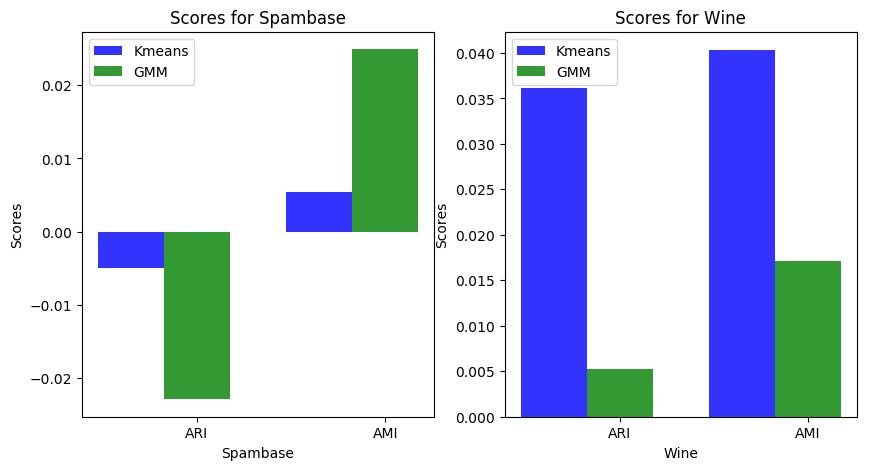

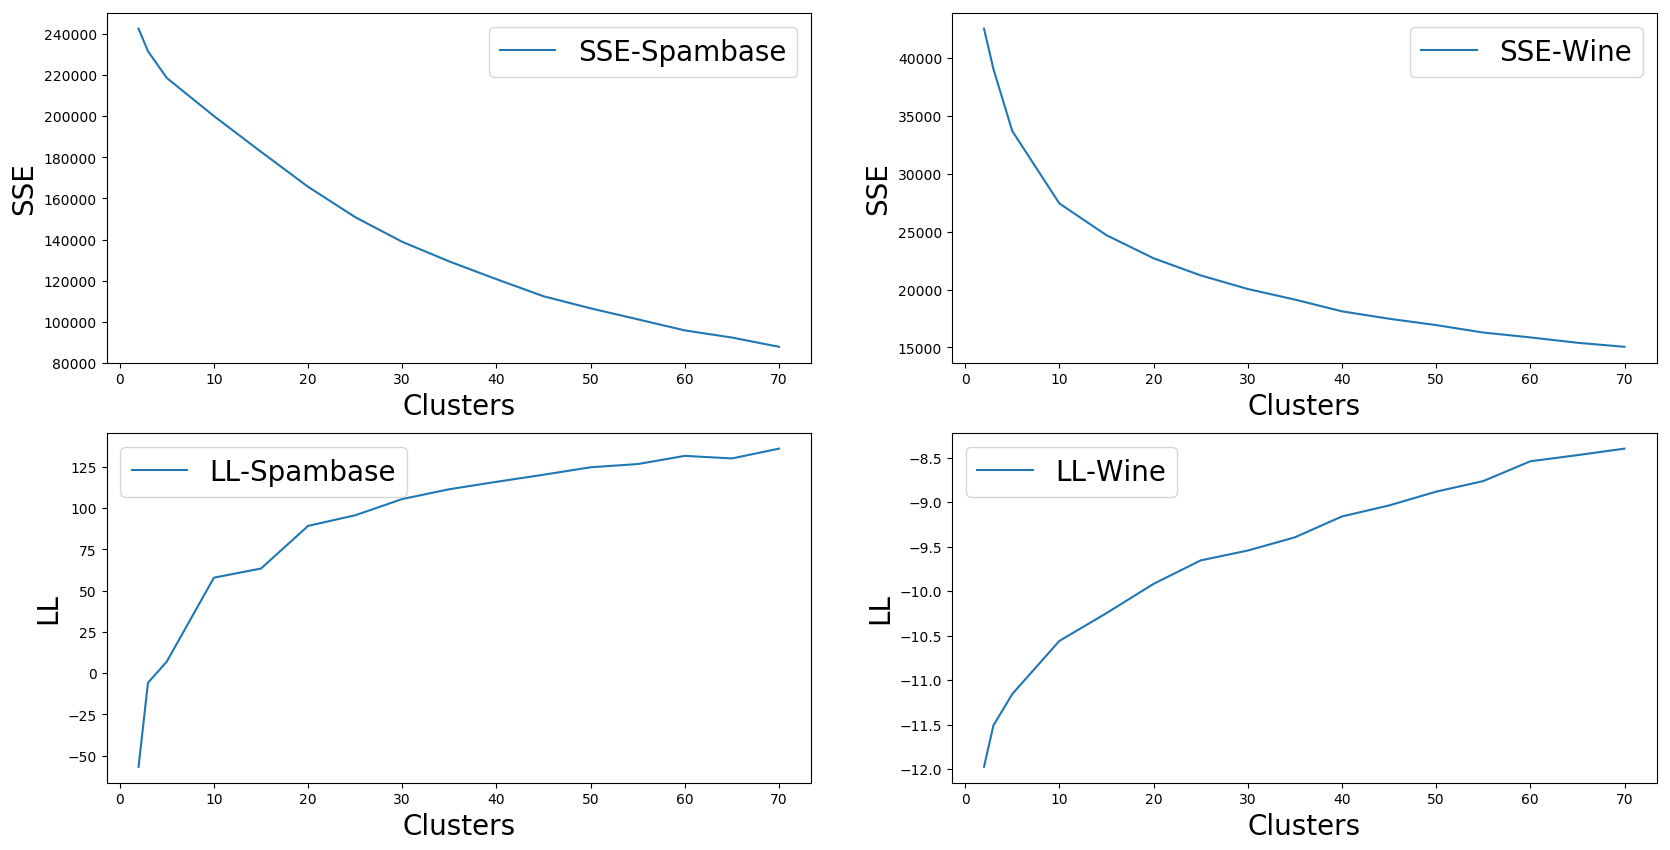

In [558]:
#train (comment out after training done)
out = '/Users/jayanth.mettu/repos/pers/gatech/ml/assign3/CS-7641-assignment-3/out/clustering/'
clusters = [2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
#run_sse_ll(out, clusters, X_train, X2_train)
k_spambase = 2
k_wine = 3
#run_clustering_metrics(out, k_spambase, k_wine, X_train, Y_train, X2_train, Y2_train)
plot_clustering_metrics(out)    
plot_clustering_sse_ll(out)

## PCA

In [24]:
pca = PCA(random_state=5)
pca.fit(X_train)
exp_var_cumsum = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_))
exp_var = pca.explained_variance_
ev_in_percent = np.array([i * 100.0 / np.sum(exp_var) for i in exp_var])
ev_in_percent_cumsum = np.cumsum(ev_in_percent)

pca2 = PCA(random_state=5)
pca2.fit(X2_train)
exp_var_cumsum2 = pd.DataFrame(np.cumsum(pca2.explained_variance_ratio_))
exp_var2 = pca2.explained_variance_
ev_in_percent2 = np.array([i * 100.0 / np.sum(exp_var2) for i in exp_var2])
ev_in_percent_cumsum2 = np.cumsum(ev_in_percent2)

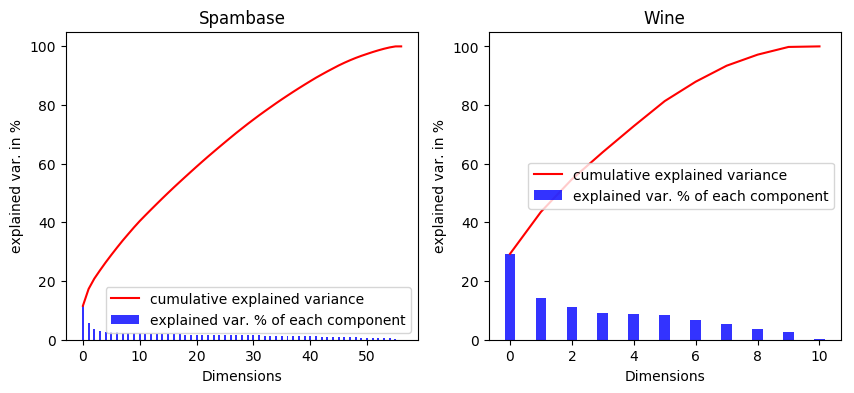

In [561]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
#plt.plot(cumsum.index, cumsum[0],  label="explained variance ratio cumsum")
plt.plot(ev_in_percent_cumsum,  label="cumulative explained variance", color = 'r')
plt.title("Spambase")
plt.xlabel("Dimensions", fontsize=10), plt.ylabel('explained var. in %', fontsize=10), plt.legend(loc="best",prop={'size':10})

n_groups = 57
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
plt.bar(index, ev_in_percent, bar_width,alpha=opacity,color='b',label='explained var. % of each component')
plt.legend()



plt.subplot(1,2,2)
#plt.plot(cumsum2.index, cumsum2[0],  label="explained variance ratio cumsum")
plt.plot(ev_in_percent_cumsum2,  label="cumulative explained variance", color = 'r')
plt.title("Wine")
plt.xlabel("Dimensions", fontsize=10), plt.ylabel('explained var. in %', fontsize=10), plt.legend(loc="best",prop={'size':10})
n_groups = 11
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
plt.bar(index, ev_in_percent2, bar_width,alpha=opacity,color='b',label='explained var. % of each component')
plt.legend()

plt.show()

#### PCA + Clustering

(4601, 2)
(4898, 2)


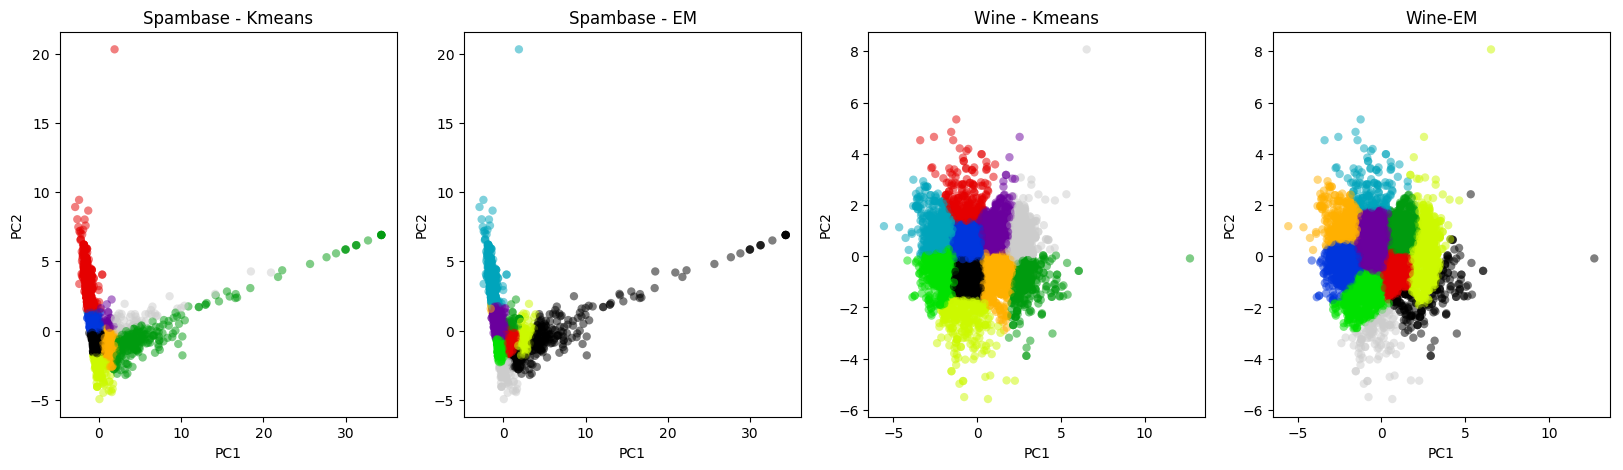

In [562]:
pca = PCA(2) # project from 64 to 2 dimensions 
projected = pca.fit_transform(X_train) 
print(projected.shape)
km = kmeans(random_state=5)
km.set_params(n_clusters=10)
km.fit(projected)
clusters = km.predict(projected)

pca2 = PCA(2) # project from 64 to 2 dimensions 
projected2 = pca2.fit_transform(X2_train) 
print(projected2.shape)

# Kmeans
km = kmeans(random_state=5)
km.set_params(n_clusters=10)
km.fit(projected2)
clusters2 = km.predict(projected2)

# Gmm
gmm = GMM(random_state=5)
gmm.set_params(n_components=10)
gmm.fit(projected2)
clusters2 = gmm.predict(projected2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))

ax1.scatter(projected[:, 0], 
             projected[:, 1],
             c=km.predict(projected), 
             edgecolor='none', 
             alpha=0.5,
             cmap=plt.cm.get_cmap('spectral', 10))    
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Spambase - Kmeans')

ax2.scatter(projected[:, 0], 
             projected[:, 1],
             c=gmm.predict(projected), 
             edgecolor='none', 
             alpha=0.5,
             cmap=plt.cm.get_cmap('spectral', 10))    
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Spambase - EM')


ax3.scatter(projected2[:, 0], 
            projected2[:, 1],
            c=km.predict(projected2),             
            edgecolor='none', 
            alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))    
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_title('Wine - Kmeans')

ax4.scatter(projected2[:, 0], 
            projected2[:, 1],
            c=gmm.predict(projected2),             
            edgecolor='none', 
            alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))    
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')
ax4.set_title('Wine-EM')


plt.show()


### PCA + ANN

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
mlp.fit(X_train_split,Y_train_split)
y_test_pred = mlp.predict(X_test_split)
orig_ann_score_spambase = accuracy_score(y_test_pred, Y_test_split)
print (orig_ann_score_spambase)

mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
mlp.fit(X2_train_split,Y2_train_split)
y2_test_pred = mlp.predict(X2_test_split)
orig_ann_score_wine = accuracy_score(y2_test_pred, Y2_test_split)
print (orig_ann_score_wine)

0.935553946416
0.602721088435


In [28]:
dims = range(1,57)
#nn_reg = [10**-x for x in range(1,5)]
#nn_arch= [(50,50),(50,),(25,),(25,25),(100,25,100)]

grid ={'pca__n_components':dims}
pca = PCA(random_state=5)       
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('pca',pca),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=False,cv=5)
gs.fit(X_train_split,Y_train_split)
pca_ann = pd.DataFrame(gs.cv_results_)
pca_ann_to_plot = pca_ann.groupby(['param_pca__n_components']).agg({'mean_train_score':'mean', 'mean_test_score':'mean'}).reset_index()

dims = range(1,12)
#nn_reg = [10**-x for x in range(1,5)]
#nn_arch= [(50,50),(50,),(25,),(25,25),(100,25,100)]

grid ={'pca__n_components':dims}
pca = PCA(random_state=5)       
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('pca',pca),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=False,cv=5)
gs.fit(X2_train_split,Y2_train_split)
pca_ann2 = pd.DataFrame(gs.cv_results_)
pca_ann_to_plot2 = pca_ann2.groupby(['param_pca__n_components']).agg({'mean_train_score':'mean', 'mean_test_score':'mean'}).reset_index()

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] pca__n_components=1 .............................................
[CV] ........ pca__n_components=1, score=0.852713178295, total=   0.1s
[CV] pca__n_components=1 .............................................
[CV] ........ pca__n_components=1, score=0.846273291925, total=   0.1s
[CV] pca__n_components=1 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV] ........ pca__n_components=1, score=0.844720496894, total=   0.0s
[CV] pca__n_components=1 .............................................
[CV] ......... pca__n_components=1, score=0.85248447205, total=   0.1s
[CV] pca__n_components=1 .............................................
[CV] ........ pca__n_components=1, score=0.827371695179, total=   0.1s
[CV] pca__n_components=2 .............................................
[CV] ........ pca__n_components=2, score=0.860465116279, total=   0.0s
[CV] pca__n_components=2 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s


[CV] ........ pca__n_components=2, score=0.855590062112, total=   0.0s
[CV] pca__n_components=2 .............................................
[CV] ........ pca__n_components=2, score=0.875776397516, total=   0.1s
[CV] pca__n_components=2 .............................................
[CV] ........ pca__n_components=2, score=0.869565217391, total=   0.1s
[CV] pca__n_components=2 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


[CV] ........ pca__n_components=2, score=0.872472783826, total=   0.0s
[CV] pca__n_components=3 .............................................
[CV] ........ pca__n_components=3, score=0.866666666667, total=   0.1s
[CV] pca__n_components=3 .............................................
[CV] ........ pca__n_components=3, score=0.869565217391, total=   0.0s
[CV] pca__n_components=3 .............................................
[CV] ........ pca__n_components=3, score=0.875776397516, total=   0.1s
[CV] pca__n_components=3 .............................................
[CV] ........ pca__n_components=3, score=0.871118012422, total=   0.0s
[CV] pca__n_components=3 .............................................
[CV] ........ pca__n_components=3, score=0.870917573872, total=   0.1s
[CV] pca__n_components=4 .............................................
[CV] ........ pca__n_components=4, score=0.840310077519, total=   0.0s
[CV] pca__n_components=4 .............................................
[CV] .

[CV] ....... pca__n_components=14, score=0.905279503106, total=   0.1s
[CV] pca__n_components=14 ............................................
[CV] ....... pca__n_components=14, score=0.888024883359, total=   0.1s
[CV] pca__n_components=15 ............................................
[CV] ....... pca__n_components=15, score=0.897674418605, total=   0.1s
[CV] pca__n_components=15 ............................................
[CV] ....... pca__n_components=15, score=0.894409937888, total=   0.1s
[CV] pca__n_components=15 ............................................
[CV] ....... pca__n_components=15, score=0.885093167702, total=   0.1s
[CV] pca__n_components=15 ............................................
[CV] ........ pca__n_components=15, score=0.91149068323, total=   0.2s
[CV] pca__n_components=15 ............................................
[CV] ....... pca__n_components=15, score=0.900466562986, total=   0.1s
[CV] pca__n_components=16 ............................................
[CV] .

[CV] ....... pca__n_components=26, score=0.899068322981, total=   0.1s
[CV] pca__n_components=26 ............................................
[CV] ....... pca__n_components=26, score=0.917701863354, total=   0.1s
[CV] pca__n_components=26 ............................................
[CV] ....... pca__n_components=26, score=0.911353032659, total=   0.1s
[CV] pca__n_components=27 ............................................
[CV] ....... pca__n_components=27, score=0.922480620155, total=   0.2s
[CV] pca__n_components=27 ............................................
[CV] ........ pca__n_components=27, score=0.92701863354, total=   0.2s
[CV] pca__n_components=27 ............................................
[CV] ....... pca__n_components=27, score=0.900621118012, total=   0.1s
[CV] pca__n_components=27 ............................................
[CV] ....... pca__n_components=27, score=0.934782608696, total=   0.1s
[CV] pca__n_components=27 ............................................
[CV] .

[CV] ........ pca__n_components=38, score=0.91007751938, total=   0.1s
[CV] pca__n_components=38 ............................................
[CV] ....... pca__n_components=38, score=0.908385093168, total=   0.1s
[CV] pca__n_components=38 ............................................
[CV] ....... pca__n_components=38, score=0.902173913043, total=   0.1s
[CV] pca__n_components=38 ............................................
[CV] ....... pca__n_components=38, score=0.933229813665, total=   0.1s
[CV] pca__n_components=38 ............................................
[CV] ....... pca__n_components=38, score=0.920684292379, total=   0.2s
[CV] pca__n_components=39 ............................................
[CV] ....... pca__n_components=39, score=0.899224806202, total=   0.1s
[CV] pca__n_components=39 ............................................
[CV] ....... pca__n_components=39, score=0.919254658385, total=   0.2s
[CV] pca__n_components=39 ............................................
[CV] .

[CV] ....... pca__n_components=50, score=0.913178294574, total=   0.1s
[CV] pca__n_components=50 ............................................
[CV] ....... pca__n_components=50, score=0.913043478261, total=   0.1s
[CV] pca__n_components=50 ............................................
[CV] ....... pca__n_components=50, score=0.908385093168, total=   0.1s
[CV] pca__n_components=50 ............................................
[CV] ....... pca__n_components=50, score=0.925465838509, total=   0.1s
[CV] pca__n_components=50 ............................................
[CV] ....... pca__n_components=50, score=0.917573872473, total=   0.1s
[CV] pca__n_components=51 ............................................
[CV] ....... pca__n_components=51, score=0.906976744186, total=   0.1s
[CV] pca__n_components=51 ............................................
[CV] ....... pca__n_components=51, score=0.902173913043, total=   0.1s
[CV] pca__n_components=51 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:   38.0s finished
/Users/jayanth.mettu/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jayanth.mettu/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jayanth.mettu/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_tr

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] pca__n_components=1 .............................................
[CV] ........ pca__n_components=1, score=0.479651162791, total=   0.2s
[CV] pca__n_components=1 .............................................
[CV] ........ pca__n_components=1, score=0.445255474453, total=   0.1s
[CV] pca__n_components=1 .............................................
[CV] ........ pca__n_components=1, score=0.456934306569, total=   0.1s
[CV] pca__n_components=1 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV] ........ pca__n_components=1, score=0.436496350365, total=   0.1s
[CV] pca__n_components=1 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


[CV] ........ pca__n_components=1, score=0.478832116788, total=   0.2s
[CV] pca__n_components=2 .............................................
[CV] ................... pca__n_components=2, score=0.5, total=   0.1s
[CV] pca__n_components=2 .............................................
[CV] ........ pca__n_components=2, score=0.433576642336, total=   0.1s

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s



[CV] pca__n_components=2 .............................................
[CV] ......... pca__n_components=2, score=0.43503649635, total=   0.1s
[CV] pca__n_components=2 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s


[CV] ........ pca__n_components=2, score=0.439416058394, total=   0.2s
[CV] pca__n_components=2 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


[CV] ........ pca__n_components=2, score=0.439416058394, total=   0.2s
[CV] pca__n_components=3 .............................................
[CV] ........ pca__n_components=3, score=0.505813953488, total=   0.8s
[CV] pca__n_components=3 .............................................
[CV] ........ pca__n_components=3, score=0.484671532847, total=   0.2s
[CV] pca__n_components=3 .............................................
[CV] ........ pca__n_components=3, score=0.500729927007, total=   0.1s
[CV] pca__n_components=3 .............................................
[CV] ........ pca__n_components=3, score=0.489051094891, total=   0.1s
[CV] pca__n_components=3 .............................................
[CV] ........ pca__n_components=3, score=0.525547445255, total=   0.1s
[CV] pca__n_components=4 .............................................
[CV] ........ pca__n_components=4, score=0.553779069767, total=   0.1s
[CV] pca__n_components=4 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    9.1s finished


In [29]:
pca_ann_to_plot['orig_ann_score_spambase'] = orig_ann_score_spambase
pca_ann_to_plot2['orig_ann_score_wine'] = orig_ann_score_wine

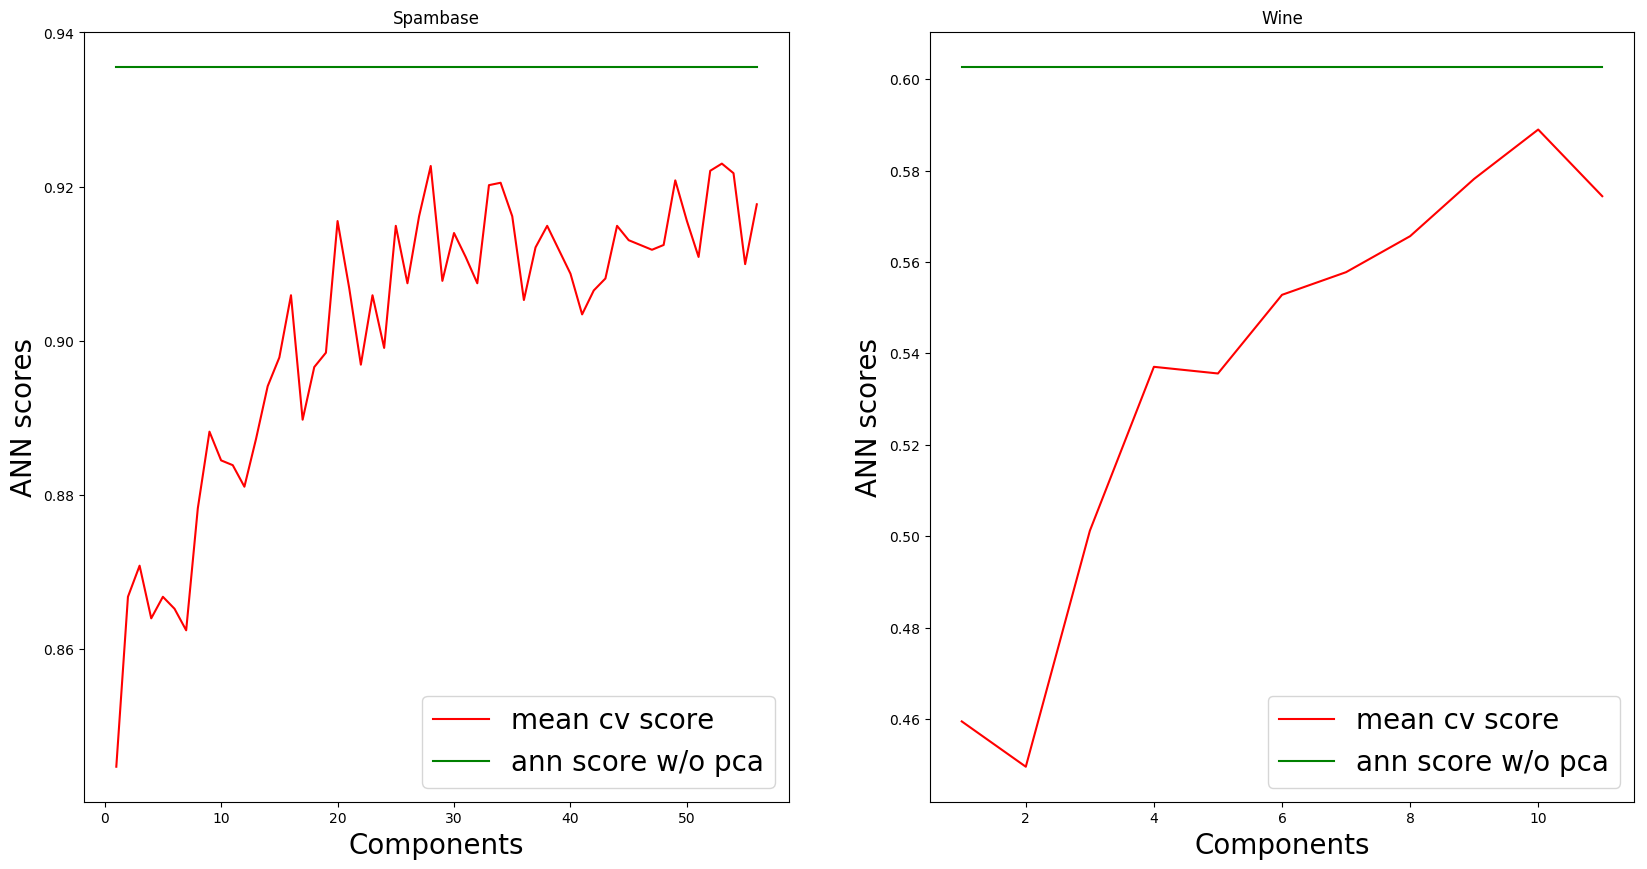

In [30]:
fig = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(pca_ann_to_plot['param_pca__n_components'],  pca_ann_to_plot['mean_test_score'], label="mean cv score", color = 'r')
plt.plot(pca_ann_to_plot['param_pca__n_components'],  pca_ann_to_plot['orig_ann_score_spambase'], label="ann score w/o pca", color = 'g')
plt.title("Spambase")
plt.xlabel("Components", fontsize=20), plt.ylabel('ANN scores', fontsize=20), plt.legend(loc="best",prop={'size':20})



plt.subplot(1,2,2)
plt.plot(pca_ann_to_plot2['param_pca__n_components'],  pca_ann_to_plot2['mean_test_score'], label="mean cv score", color = 'r')
plt.plot(pca_ann_to_plot2['param_pca__n_components'],  pca_ann_to_plot2['orig_ann_score_wine'], label="ann score w/o pca", color = 'g')
plt.title("Wine")
plt.xlabel("Components", fontsize=20), plt.ylabel('ANN scores', fontsize=20), plt.legend(loc="best",prop={'size':20})

plt.show()

### PCA + Clustering + ANN

In [563]:
dim = 20
pca = PCA(n_components=dim,random_state=10)
spambase_X_train = pca.fit_transform(X_train)
df1_new = pd.DataFrame(np.hstack((spambase_X_train,np.atleast_2d(Y_train).T)))
df1_new = shuffle(df1_new)
Y_pca_cl_ann = df1_new.iloc[:, -1]
X_pca_cl_ann = df1_new.iloc[:, :-1]
X_pca_cl_ann_train, Y_pca_cl_ann_train = X_pca_cl_ann, Y_pca_cl_ann
sc = StandardScaler()
X_pca_cl_ann_train = sc.fit_transform(X_pca_cl_ann_train)
X_pca_cl_ann_train = np.array(X_pca_cl_ann_train)
Y_pca_cl_ann_train = np.array(Y_pca_cl_ann_train)
X_pca_cl_ann_train_split, X_pca_cl_ann_test_split, Y_pca_cl_ann_train_split, Y_pca_cl_ann_test_split = train_test_split(X_pca_cl_ann_train, Y_pca_cl_ann_train, test_size=0.3, random_state=42)



dim = 6
pca = PCA(n_components=dim,random_state=10)
wine_X_train = pca.fit_transform(X2_train)
df2_new = pd.DataFrame(np.hstack((wine_X_train,np.atleast_2d(Y2_train).T)))
df2_new = shuffle(df2_new)
Y2_pca_cl_ann = df2_new.iloc[:, -1]
X2_pca_cl_ann = df2_new.iloc[:, :-1]
X2_pca_cl_ann_train, Y2_pca_cl_ann_train = X2_pca_cl_ann, Y2_pca_cl_ann
sc = StandardScaler()
X2_pca_cl_ann_train = sc.fit_transform(X2_pca_cl_ann_train)
X2_pca_cl_ann_train = np.array(X2_pca_cl_ann_train)
Y2_pca_cl_ann_train = np.array(Y2_pca_cl_ann_train)
X2_pca_cl_ann_train_split, X2_pca_cl_ann_test_split, Y2_pca_cl_ann_train_split, Y2_pca_cl_ann_test_split = train_test_split(X2_pca_cl_ann_train, Y2_pca_cl_ann_train, test_size=0.3, random_state=42)



In [564]:
print type(X2_pca_cl_ann_train)
print type(X2_train)
print (X2_pca_cl_ann_train.shape)
print (X2_train.shape)

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(4898, 6)
(4898, 11)


In [565]:
#train (comment out after training done)
out = '/Users/jayanth.mettu/repos/pers/gatech/ml/assign3/CS-7641-assignment-3/out/pca_clustering_ann/'
clusters = [2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
run_sse_ll(out, clusters, X_pca_cl_ann_train, X2_pca_cl_ann_train_split)
k_spambase = 20
k_wine = 6
run_clustering_metrics(out, k_spambase, k_wine, X_pca_cl_ann_train_split, Y_pca_cl_ann_train_split, X2_pca_cl_ann_train_split, Y2_pca_cl_ann_train_split)
plot_clustering_metrics(out)    
plot_clustering_sse_ll(out)

(2, 1.0777060000000347)
(3, 2.5900779999992665)
(5, 5.091838999998799)
(10, 10.124293999999281)
(15, 15.486300000000483)
(20, 24.812769000000117)
(25, 33.848291999998764)
(30, 43.32474899999943)
(35, 58.12964099999954)
(40, 80.17369099999996)
(45, 104.34706199999891)
(50, 135.4467169999989)
(55, 154.63070499999958)
(60, 179.7922120000003)
(65, 205.61236599999938)
(70, 231.2451799999999)


KeyError: u'the label [2] is not in the [index]'

## ICA

In [82]:
dims = [57]
kurt_spambase = {}
kurt_spambase_mean = {}
kurt_wine_mean = {}
for dim in dims:
    ica = FastICA(random_state=5)
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X_train)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt_spambase[dim] = tmp
    kurt_spambase_mean[dim] = tmp.abs().mean
kurt_spambase_mean = pd.Series(kurt_spambase_mean) 

dims = [12]
ica = FastICA(random_state=5)
kurt_wine = {}
for dim in dims:
    ica = FastICA(random_state=5)
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X2_train)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt_wine[dim] = tmp
    kurt_wine_mean[dim] = tmp.abs().mean    
kurt_wine_mean = pd.Series(kurt_wine_mean) 

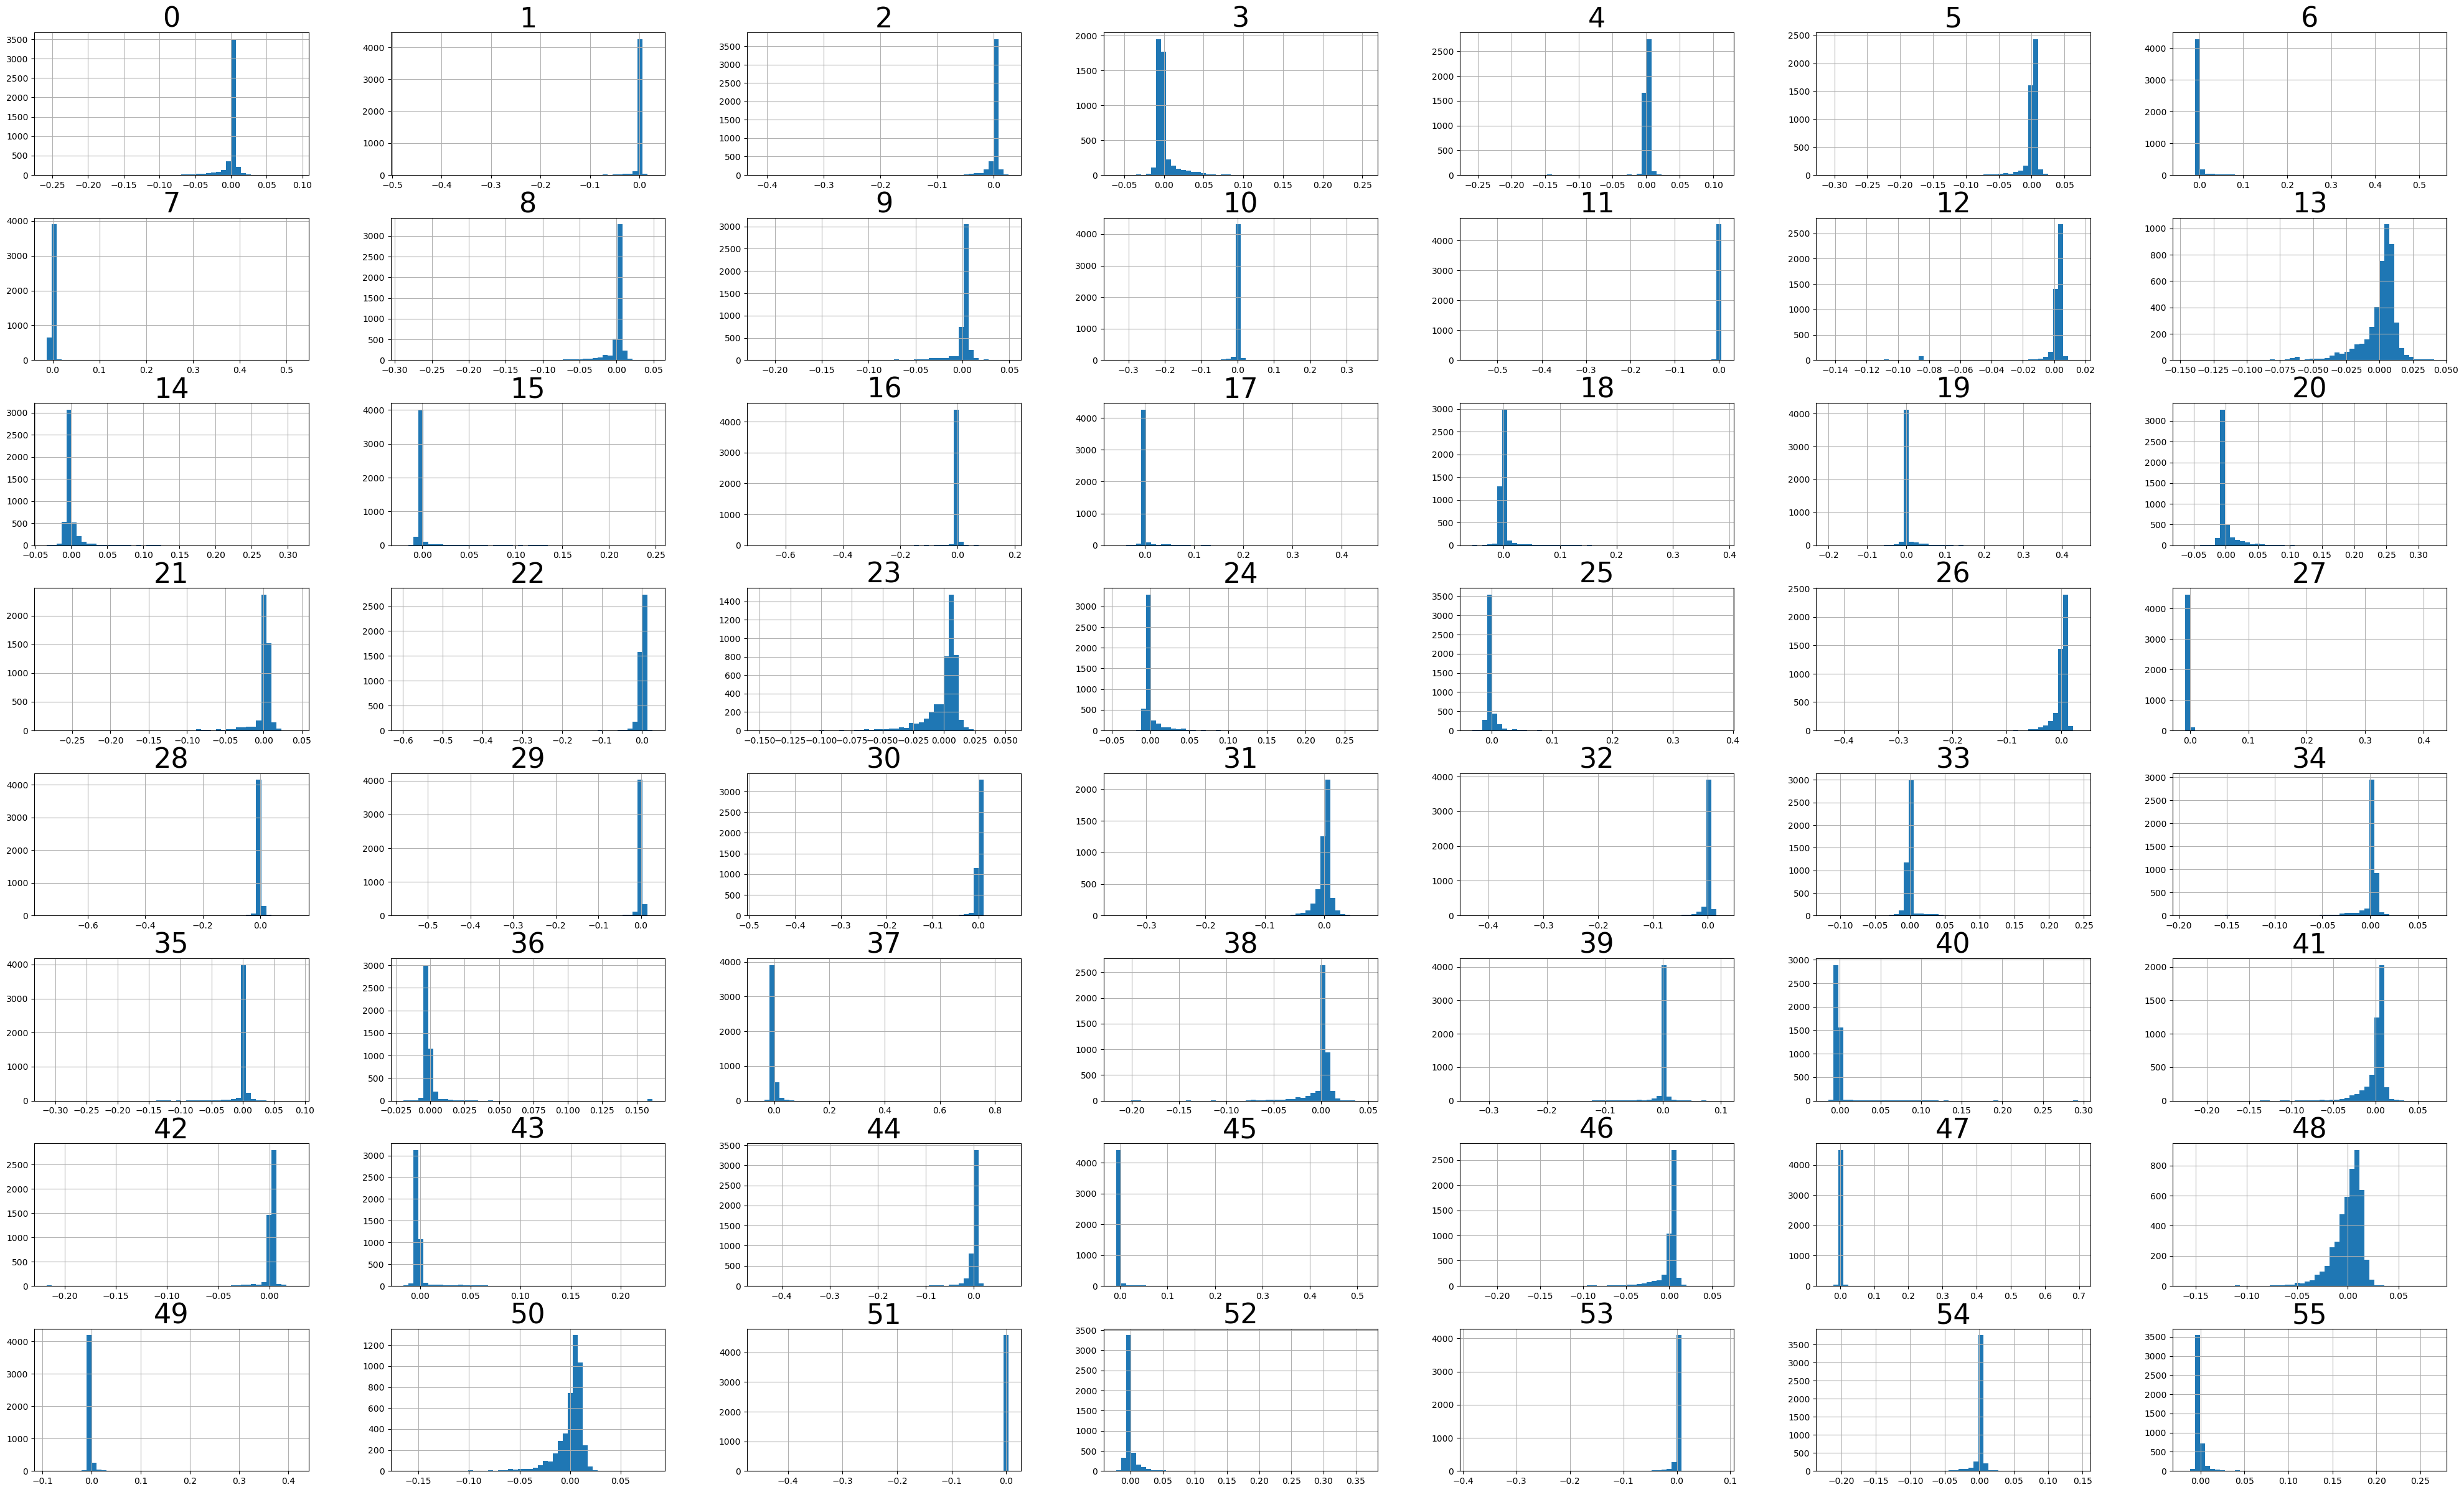

In [109]:
ica = FastICA(random_state=5)
ica.set_params(n_components=56)
tmp = ica.fit_transform(X_train)
tmp = pd.DataFrame(tmp)
fig = tmp.hist(figsize=(50, 30), bins=50)
[x.title.set_size(32) for x in fig.ravel()]
plt.show()

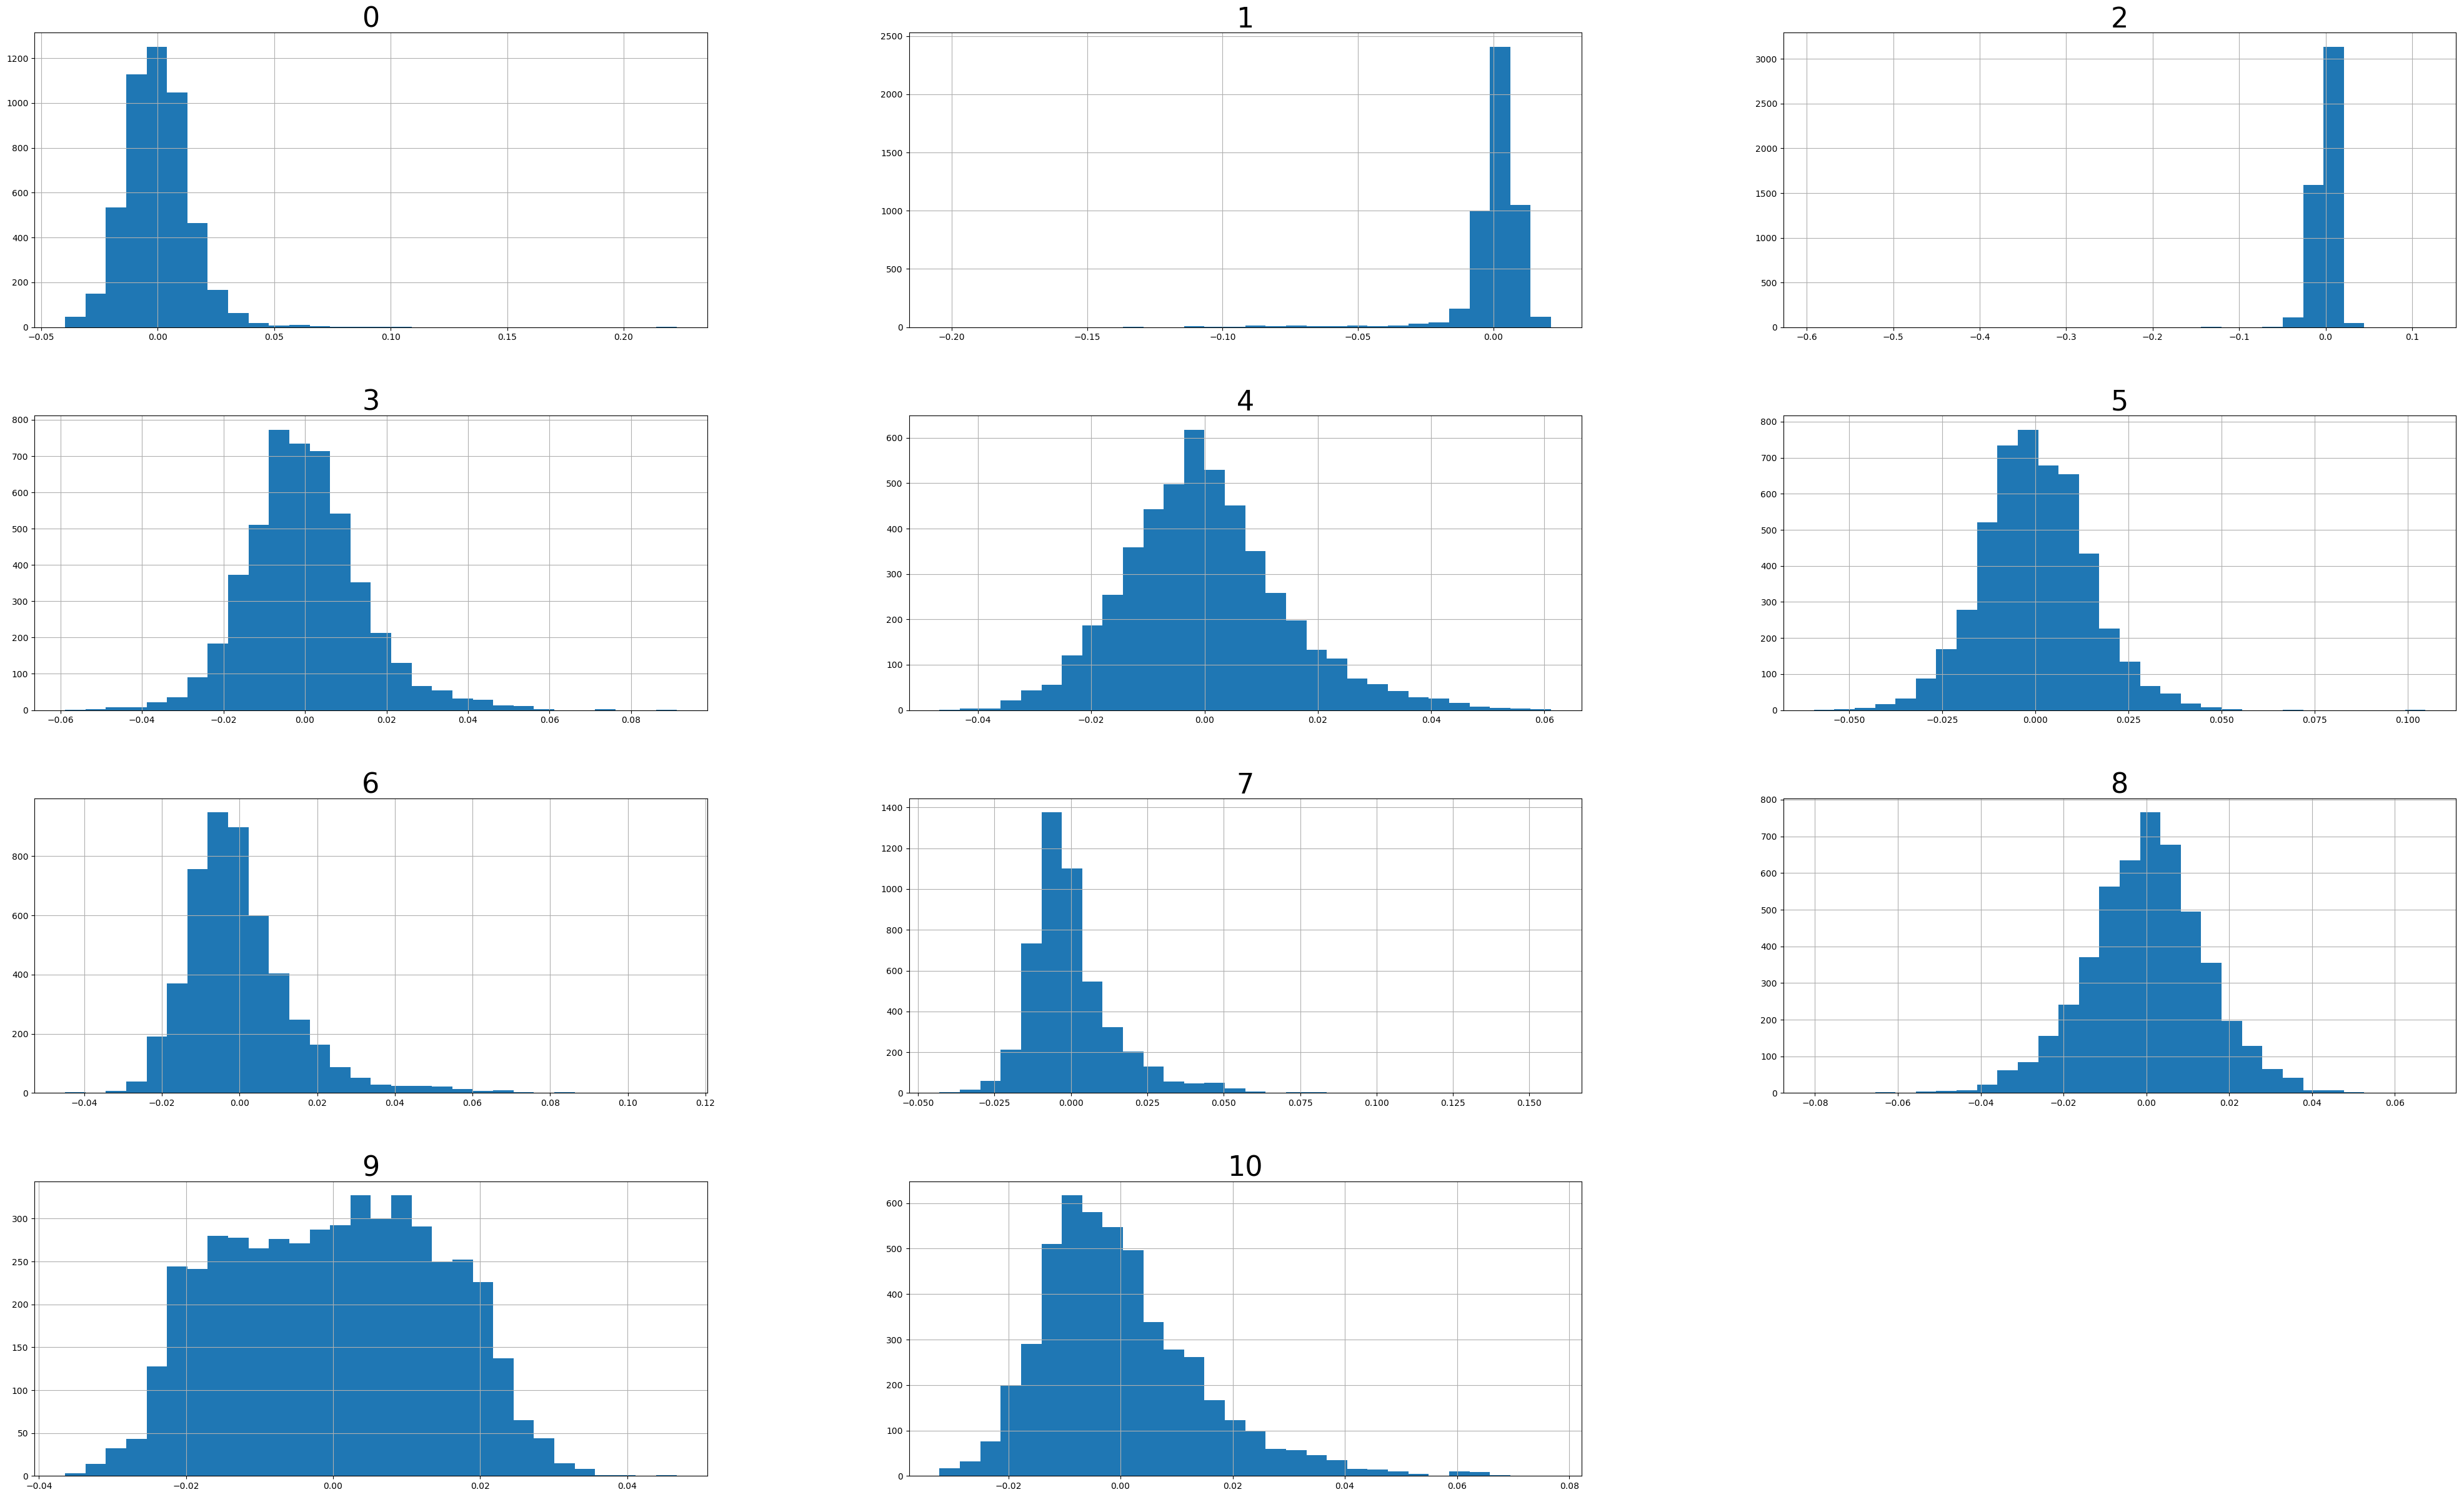

In [110]:
ica = FastICA(random_state=5)
ica.set_params(n_components=11)
tmp = ica.fit_transform(X2_train)
tmp = pd.DataFrame(tmp)
fig = tmp.hist(figsize=(50, 30), bins=30)
[x.title.set_size(32) for x in fig.ravel()]
plt.show()

In [221]:
dims = range(1,57)
kurt = {}
for dim in dims:
    ica = FastICA(random_state=5)
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X_train)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[dim] = tmp.abs().mean()
kurt = pd.Series(kurt)    
kurt.sort_values(inplace=True, ascending=False)

dims = range(1,12)
kurt2 = {}
for dim in dims:
    ica = FastICA(random_state=5)
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X2_train)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt2[dim] = tmp.abs().mean()
kurt2 = pd.Series(kurt2)   
kurt2.sort_values(inplace=True, ascending=False)




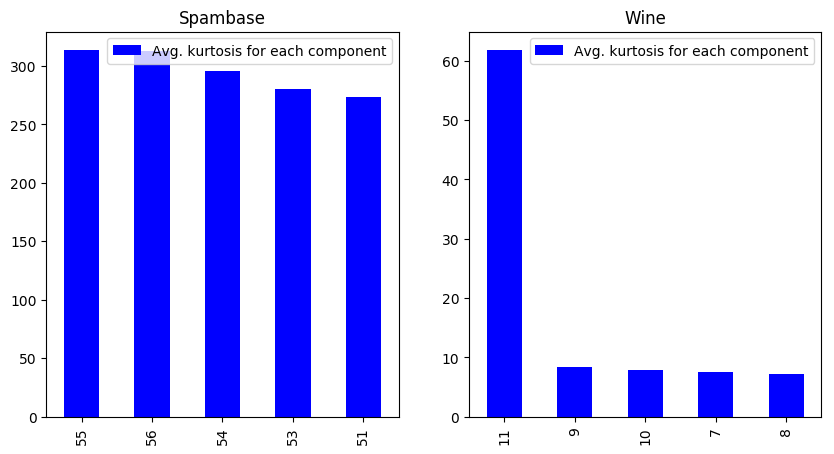

In [569]:
tmp_kurt = kurt[0:5]
tmp_kurt2 = kurt2[0:5]
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
tmp_kurt.plot(kind='bar', title='Spambase', label='Avg. kurtosis for each component', color='b')
plt.legend()
plt.subplot(1,2,2)
tmp_kurt2.plot(kind='bar', title='Wine', label='Avg. kurtosis for each component', color='b')
plt.legend()
plt.show()

### ICA + clustering

In [251]:
ica = FastICA(random_state=5)
ica.set_params(n_components=57)
projected = ica.fit_transform(X_train) 
projected[:, 55]
(np.vstack((projected[:, 55],projected[:, 56])).T).shape


(4601, 2)

(4601, 2)
(4898, 2)


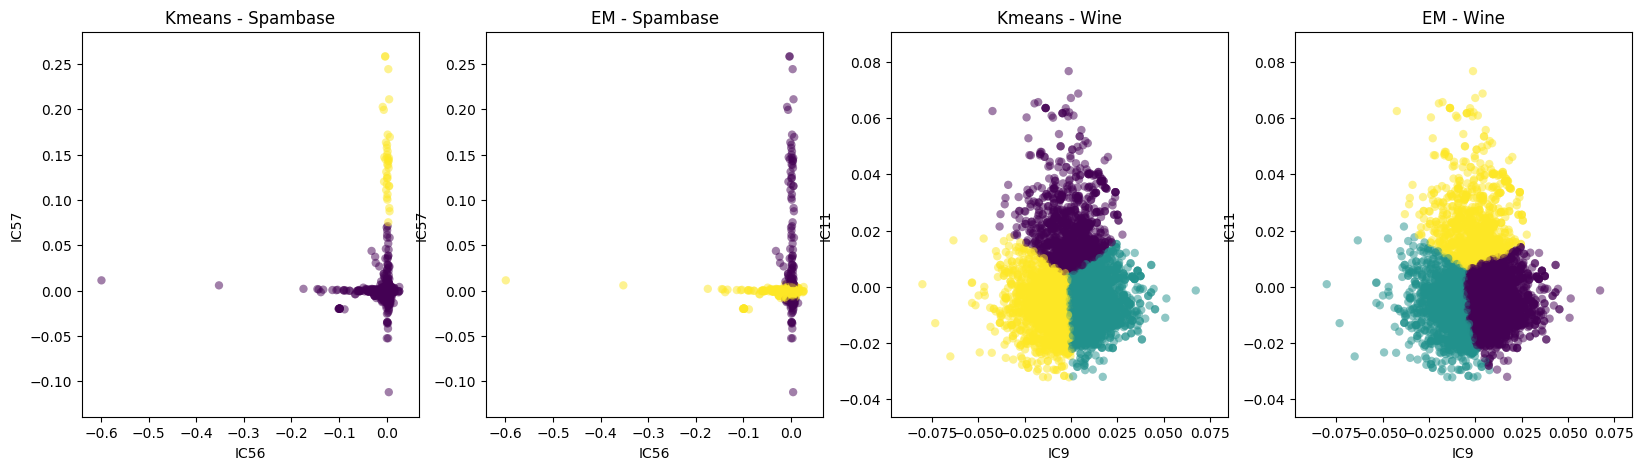

In [368]:
ica = FastICA(random_state=5)
ica.set_params(n_components=57)
projected = ica.fit_transform(X_train) 
reshaped = (np.vstack((projected[:, 55],projected[:, 56])).T)
print(reshaped.shape)

km = kmeans(random_state=5)
km.set_params(n_clusters=2)
km.fit(reshaped)

# Gmm
gmm = GMM(random_state=5)
gmm.set_params(n_components=2)
gmm.fit(reshaped)


ica2 = FastICA(random_state=5)
ica2.set_params(n_components=11)
projected2 = ica.fit_transform(X2_train) 
reshaped2 = (np.vstack((projected2[:, 8],projected2[:, 10])).T)
print(reshaped2.shape)

# Kmeans
km2 = kmeans(random_state=5)
km2.set_params(n_clusters=3)
km2.fit(reshaped2)

# Gmm
gmm2 = GMM(random_state=5)
gmm2.set_params(n_components=3)
gmm2.fit(reshaped2)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))

ax1.scatter(projected[:, 55], 
             projected[:, 56],
             c=km.predict(reshaped), 
             edgecolor='none', 
             alpha=0.5)    
ax1.set_xlabel('IC56')
ax1.set_ylabel('IC57')
ax1.set_title('Kmeans - Spambase')

ax2.scatter(projected[:, 55], 
             projected[:, 56],
             c=gmm.predict(reshaped), 
             edgecolor='none', 
             alpha=0.5)    
ax2.set_xlabel('IC56')
ax2.set_ylabel('IC57')
ax2.set_title('EM - Spambase')


ax3.scatter(projected2[:, 8], 
            projected2[:, 10],
            c=km2.predict(reshaped2),             
            edgecolor='none', 
            alpha=0.5)    
ax3.set_xlabel('IC9')
ax3.set_ylabel('IC11')
ax3.set_title('Kmeans - Wine')

ax4.scatter(projected2[:, 8], 
            projected2[:, 10],
            c=gmm2.predict(reshaped2),             
            edgecolor='none', 
            alpha=0.5)    
ax4.set_xlabel('IC9')
ax4.set_ylabel('IC11')
ax4.set_title('EM - Wine')


plt.show()


### ICA + ANN

In [275]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
mlp.fit(X_train_split,Y_train_split)
y_test_pred = mlp.predict(X_test_split)
orig_ann_score_spambase = accuracy_score(y_test_pred, Y_test_split)
print (orig_ann_score_spambase)

mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
mlp.fit(X2_train_split,Y2_train_split)
y2_test_pred = mlp.predict(X2_test_split)
orig_ann_score_wine = accuracy_score(y2_test_pred, Y2_test_split)
print (orig_ann_score_wine)

0.935553946416
0.602721088435


In [282]:
dims = range(1,57)
grid ={'ica__n_components':dims}
ica = FastICA(random_state=5)       
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('ica',ica),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=False,cv=5)
gs.fit(X_train_split,Y_train_split)
ica_ann = pd.DataFrame(gs.cv_results_)
ica_ann_to_plot = ica_ann.groupby(['param_ica__n_components']).agg({'mean_train_score':'mean', 'mean_test_score':'mean'}).reset_index()

dims = range(1,12)
grid ={'ica__n_components':dims}
ica = FastICA(random_state=5)       
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('ica',ica),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=False,cv=5)
gs.fit(X2_train_split,Y2_train_split)
ica_ann2 = pd.DataFrame(gs.cv_results_)
ica_ann_to_plot2 = ica_ann2.groupby(['param_ica__n_components']).agg({'mean_train_score':'mean', 'mean_test_score':'mean'}).reset_index()

In [283]:
ica_ann

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_ica__n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.059958,0.000772,0.616149,0.616149,1,{u'ica__n_components': 1},21,0.615504,0.616311,0.616460,...,0.616460,0.616071,0.616460,0.616071,0.615863,0.616220,0.017599,0.000155,0.000397,0.000099
1,0.046534,0.001119,0.616149,0.616149,2,{u'ica__n_components': 2},21,0.615504,0.616311,0.616460,...,0.616460,0.616071,0.616460,0.616071,0.615863,0.616220,0.007471,0.000368,0.000397,0.000099
2,0.059946,0.000886,0.616149,0.616304,3,{u'ica__n_components': 3},21,0.615504,0.616311,0.616460,...,0.616460,0.616460,0.616460,0.615683,0.615863,0.616608,0.009709,0.000078,0.000397,0.000325
3,0.050616,0.000869,0.616149,0.616149,4,{u'ica__n_components': 4},21,0.615504,0.616311,0.616460,...,0.616460,0.616071,0.616460,0.616071,0.615863,0.616220,0.004190,0.000111,0.000397,0.000099
4,0.057918,0.001310,0.618634,0.618168,5,{u'ica__n_components': 5},8,0.615504,0.618252,0.619565,...,0.616460,0.616071,0.625776,0.622671,0.615863,0.616220,0.007335,0.000516,0.003849,0.002399
5,0.060212,0.000982,0.616149,0.616149,6,{u'ica__n_components': 6},21,0.615504,0.616311,0.616460,...,0.616460,0.616071,0.616460,0.616071,0.615863,0.616220,0.006719,0.000224,0.000397,0.000099
6,0.051902,0.000858,0.616149,0.616149,7,{u'ica__n_components': 7},21,0.615504,0.616311,0.616460,...,0.616460,0.616071,0.616460,0.616071,0.615863,0.616220,0.005207,0.000161,0.000397,0.000099
7,0.090754,0.000937,0.615528,0.615450,8,{u'ica__n_components': 8},55,0.613953,0.617087,0.618012,...,0.613354,0.611801,0.616460,0.616071,0.615863,0.616220,0.040918,0.000330,0.001695,0.001863
8,0.097732,0.001301,0.616460,0.616149,9,{u'ica__n_components': 9},17,0.615504,0.616311,0.616460,...,0.616460,0.616071,0.618012,0.616071,0.615863,0.616220,0.046044,0.000278,0.000858,0.000099
9,0.112100,0.001359,0.616149,0.616227,10,{u'ica__n_components': 10},21,0.615504,0.616311,0.616460,...,0.616460,0.616071,0.616460,0.616071,0.615863,0.616608,0.008583,0.000556,0.000397,0.000212


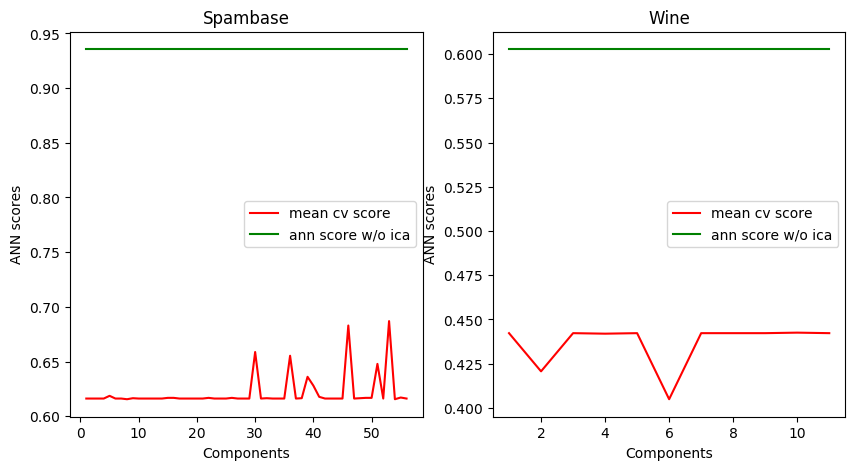

In [571]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(ica_ann_to_plot['param_ica__n_components'],  ica_ann_to_plot['mean_test_score'], label="mean cv score", color = 'r')
plt.plot(ica_ann_to_plot['param_ica__n_components'],  ica_ann_to_plot['orig_ann_score_spambase'], label="ann score w/o ica", color = 'g')
plt.title("Spambase")
plt.xlabel("Components", fontsize=10), plt.ylabel('ANN scores', fontsize=10), plt.legend(loc="best",prop={'size':10})



plt.subplot(1,2,2)
plt.plot(ica_ann_to_plot2['param_ica__n_components'],  ica_ann_to_plot2['mean_test_score'], label="mean cv score", color = 'r')
plt.plot(ica_ann_to_plot2['param_ica__n_components'],  ica_ann_to_plot2['orig_ann_score_wine'], label="ann score w/o ica", color = 'g')
plt.title("Wine")
plt.xlabel("Components", fontsize=10), plt.ylabel('ANN scores', fontsize=10), plt.legend(loc="best",prop={'size':10})

plt.show()

## RP

In [310]:
# from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
# from itertools import product
# from sklearn.metrics.pairwise import pairwise_distances
# import scipy.sparse as sps
# from scipy.linalg import pinv

# def reconstructionError(projections,X):
#     W = projections.components_
#     if sps.issparse(W):
#         W = W.todense()
#     p = pinv(W)
#     t1 = np.dot(p,W)
#     reconstructed = (np.dot(t1,X.T)).T # Unproject projected data
#     errors = np.square(X-reconstructed)
#     return np.nanmean(errors)

# def pairwiseDistCorr(X1,X2):
#     assert X1.shape[0] == X2.shape[0]
    
#     d1 = pairwise_distances(X1)
#     d2 = pairwise_distances(X2)
#     return np.corrcoef(d1.ravel(),d2.ravel())[0,1]


# dims = range(1,57)
# distcorr_spambase = defaultdict(dict)
# for i,dim in product(range(10),dims):
#     rp = SparseRandomProjection(random_state=i, n_components=dim)
#     distcorr_spambase[dim][i] = pairwiseDistCorr(rp.fit_transform(X_train), X_train)
# distcorr_spambase =pd.DataFrame(distcorr_spambase).T

# reconserror_spambase = defaultdict(dict)
# for i,dim in product(range(10),dims):
#     rp = SparseRandomProjection(random_state=i, n_components=dim)
#     rp.fit(X_train)    
#     reconserror_spambase[dim][i] = reconstructionError(rp, X_train)
# reconserror_spambase =pd.DataFrame(reconserror_spambase).T

# dims = range(1,12)
# distcorr_wine = defaultdict(dict)
# for i,dim in product(range(10),dims):
#     rp = SparseRandomProjection(random_state=i, n_components=dim)
#     distcorr_wine[dim][i] = pairwiseDistCorr(rp.fit_transform(X2_train), X2_train)
# distcorr_wine =pd.DataFrame(distcorr_wine).T

# reconserror_wine = defaultdict(dict)
# for i,dim in product(range(10),dims):
#     rp = SparseRandomProjection(random_state=i, n_components=dim)
#     rp.fit(X2_train)    
#     reconserror_wine[dim][i] = reconstructionError(rp, X2_train)
# reconserror_wine =pd.DataFrame(reconserror_wine).T


In [313]:
out = '/Users/jayanth.mettu/repos/pers/gatech/ml/assign3/CS-7641-assignment-3/out/rp/'
distcorr_spambase.to_csv(out+'spambase scree1.csv')
distcorr_wine.to_csv(out+'wine scree1.csv')
reconserror_spambase.to_csv(out+'spambase scree2.csv')
reconserror_wine.to_csv(out+'wine scree2.csv')

distcorr_spambase = pd.read_csv(out+'spambase scree1.csv')
distcorr_wine = pd.read_csv(out+'wine scree1.csv')
reconserror_spambase = pd.read_csv(out+'spambase scree2.csv')
reconserror_wine = pd.read_csv(out+'wine scree2.csv')

distcorr_spambase = distcorr_spambase.ix[:,1:]
distcorr_wine = distcorr_wine.ix[:,1:]
reconserror_spambase = reconserror_spambase.ix[:,1:]
reconserror_wine = reconserror_wine.ix[:,1:]


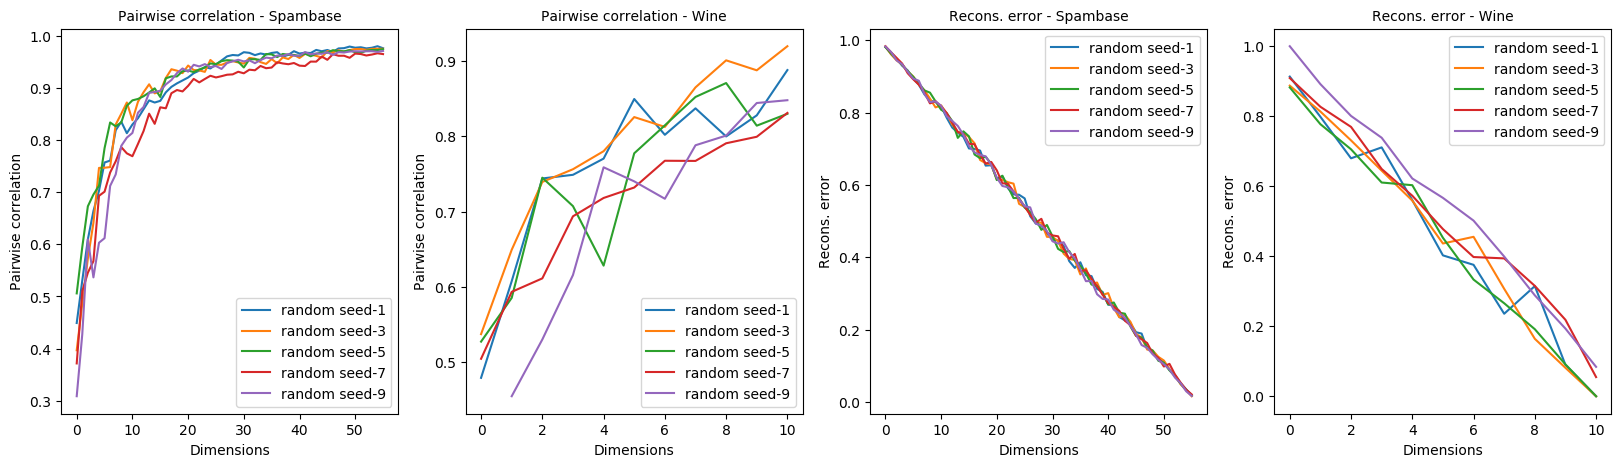

In [367]:
fig = plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
for i in range(1,10,2):
    plt.plot(distcorr_spambase.index, distcorr_spambase['{}'.format(i)],  label="random seed-{}".format(i))
plt.title("Pairwise correlation - Spambase", size=10)
plt.xlabel("Dimensions", fontsize=10), plt.ylabel('Pairwise correlation', fontsize=10), plt.legend(loc="best",prop={'size':10})

plt.subplot(1,4,2)  
for i in range(1,10,2):
    plt.plot(distcorr_wine.index, distcorr_wine['{}'.format(i)],  label="random seed-{}".format(i))
plt.title("Pairwise correlation - Wine", size=10)
plt.xlabel("Dimensions", fontsize=10), plt.ylabel('Pairwise correlation', fontsize=10), plt.legend(loc="best",prop={'size':10})

plt.subplot(1,4,3)  
for i in range(1,10,2):
    plt.plot(reconserror_spambase.index, reconserror_spambase['{}'.format(i)],  label="random seed-{}".format(i))
plt.title("Recons. error - Spambase", size=10)
plt.xlabel("Dimensions", fontsize=10), plt.ylabel('Recons. error', fontsize=10), plt.legend(loc="best",prop={'size':10})

plt.subplot(1,4,4)  
for i in range(1,10,2):
    plt.plot(reconserror_wine.index, reconserror_wine['{}'.format(i)],  label="random seed-{0}".format(i))
plt.title("Recons. error - Wine", size=10)
plt.xlabel("Dimensions", fontsize=10), plt.ylabel('Recons. error', fontsize=10), plt.legend(loc="best",prop={'size':10})

plt.show()

### RP + ANN

In [369]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
mlp.fit(X_train_split,Y_train_split)
y_test_pred = mlp.predict(X_test_split)
orig_ann_score_spambase = accuracy_score(y_test_pred, Y_test_split)
print (orig_ann_score_spambase)

mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
mlp.fit(X2_train_split,Y2_train_split)
y2_test_pred = mlp.predict(X2_test_split)
orig_ann_score_wine = accuracy_score(y2_test_pred, Y2_test_split)
print (orig_ann_score_wine)

0.935553946416
0.602721088435


In [375]:
dims = range(1,57)
grid ={'rp__n_components':dims}
rp = SparseRandomProjection(random_state=5)       
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('rp',rp),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=False,cv=5)

gs.fit(X_train_split,Y_train_split)
rp_ann = pd.DataFrame(gs.cv_results_)
rp_ann_to_plot = rp_ann.groupby(['param_rp__n_components']).agg({'mean_train_score':'mean', 'mean_test_score':'mean'}).reset_index()


dims = range(1,12)
grid ={'rp__n_components':dims}
rp = SparseRandomProjection(random_state=5)
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('rp',rp),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=False,cv=5)
gs.fit(X2_train_split,Y2_train_split)
rp_ann2 = pd.DataFrame(gs.cv_results_)
rp_ann_to_plot2 = rp_ann2.groupby(['param_rp__n_components']).agg({'mean_train_score':'mean', 'mean_test_score':'mean'}).reset_index()

rp_ann_to_plot['orig_ann_score_spambase'] = orig_ann_score_spambase
rp_ann_to_plot2['orig_ann_score_wine'] = orig_ann_score_wine



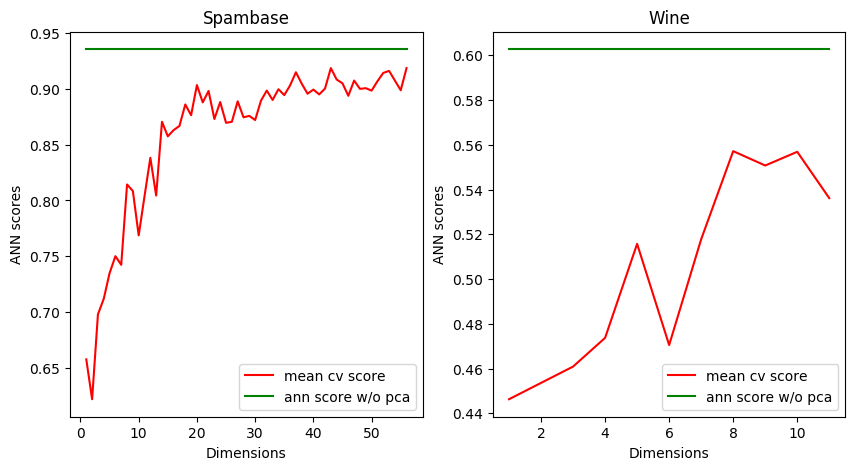

In [381]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(rp_ann_to_plot['param_rp__n_components'],  rp_ann_to_plot['mean_test_score'], label="mean cv score", color = 'r')
plt.plot(rp_ann_to_plot['param_rp__n_components'],  rp_ann_to_plot['orig_ann_score_spambase'], label="ann score w/o pca", color = 'g')
plt.title("Spambase")
plt.xlabel("Dimensions", fontsize=10), plt.ylabel('ANN scores', fontsize=10), plt.legend(loc="best",prop={'size':10})



plt.subplot(1,2,2)
plt.plot(rp_ann_to_plot2['param_rp__n_components'],  rp_ann_to_plot2['mean_test_score'], label="mean cv score", color = 'r')
plt.plot(rp_ann_to_plot2['param_rp__n_components'],  rp_ann_to_plot2['orig_ann_score_wine'], label="ann score w/o pca", color = 'g')
plt.title("Wine")
plt.xlabel("Dimensions", fontsize=10), plt.ylabel('ANN scores', fontsize=10), plt.legend(loc="best",prop={'size':10})

plt.show()

### RP + Clustering

In [398]:
dim = 20
rp = SparseRandomProjection(n_components=dim,random_state=5)
projected = rp.fit_transform(X_train)
last = projected[:,-1]
last_2 = projected[:,-2]


(4601, 2)

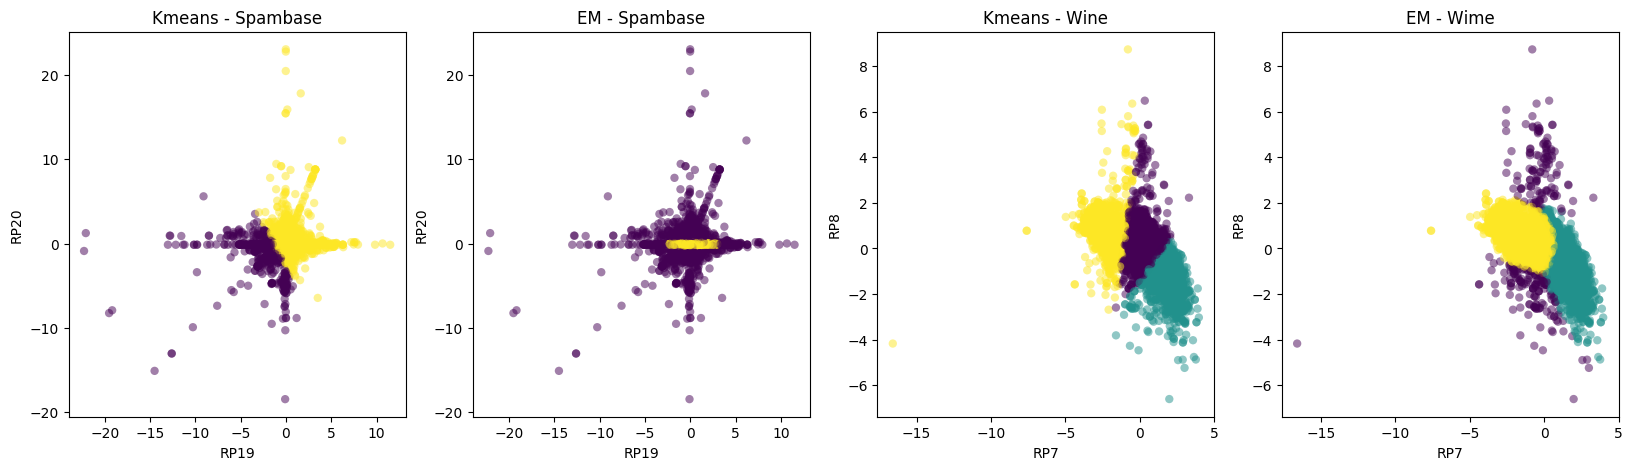

In [597]:
dim = 20
rp = SparseRandomProjection(n_components=dim,random_state=5)
projected = rp.fit_transform(X_train)
reshaped = (np.vstack((projected[:, -1],projected[:, -2])).T)

km = kmeans(random_state=5)
km.set_params(n_clusters=2)
km.fit(reshaped)


gmm = GMM(random_state=5)
gmm.set_params(n_components=2)
gmm.fit(reshaped)


# Dataset-2
dim = 8
rp = SparseRandomProjection(n_components=dim,random_state=5)
projected2 = rp.fit_transform(X2_train)
reshaped2 = (np.vstack((projected2[:, -1],projected2[:, -2])).T)

km2 = kmeans(random_state=5)
km2.set_params(n_clusters=3)
km2.fit(reshaped2)


gmm2 = GMM(random_state=5)
gmm2.set_params(n_components=3)
gmm2.fit(reshaped2)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))

ax1.scatter(reshaped[:,0], 
             reshaped[:,1],
             c=km.predict(reshaped), 
             edgecolor='none', 
             alpha=0.5)    
ax1.set_xlabel('RP19')
ax1.set_ylabel('RP20')
ax1.set_title('Kmeans - Spambase')

ax2.scatter(reshaped[:,0], 
             reshaped[:,1],
             c=gmm.predict(reshaped), 
             edgecolor='none', 
             alpha=0.5)    
ax2.set_xlabel('RP19')
ax2.set_ylabel('RP20')
ax2.set_title('EM - Spambase')


ax3.scatter(reshaped2[:, 0], 
            reshaped2[:, 1],
            c=km2.predict(reshaped2),             
            edgecolor='none', 
            alpha=0.5)    
ax3.set_xlabel('RP7')
ax3.set_ylabel('RP8')
ax3.set_title('Kmeans - Wine')

ax4.scatter(reshaped2[:, 0], 
            reshaped2[:, 1],
            c=gmm2.predict(reshaped2),             
            edgecolor='none', 
            alpha=0.5)    
ax4.set_xlabel('RP7')
ax4.set_ylabel('RP8')
ax4.set_title('EM - Wime')


plt.show()


## RF

In [486]:
from sklearn.ensemble import RandomForestClassifier
out = '/Users/jayanth.mettu/repos/pers/gatech/ml/assign3/CS-7641-assignment-3/out/rf/'
clusters =  range(1,40)
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=7)
fs_spambase = rfc.fit(X_train,Y_train).feature_importances_ 
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=7)
fs_wine = rfc.fit(X2_train,Y2_train).feature_importances_ 

fs_spambase = pd.DataFrame(fs_spambase)
fs_spambase = fs_spambase.sort_values(by=[0], ascending=False)

fs_wine = pd.DataFrame(fs_wine)
fs_wine = fs_wine.sort_values(by=[0], ascending=False)
    

In [572]:
fs_wine

,0
10,0.136103
7,0.113419
1,0.098745
5,0.092108
6,0.089097
4,0.086465
3,0.084588
8,0.079773
2,0.078747
9,0.071660


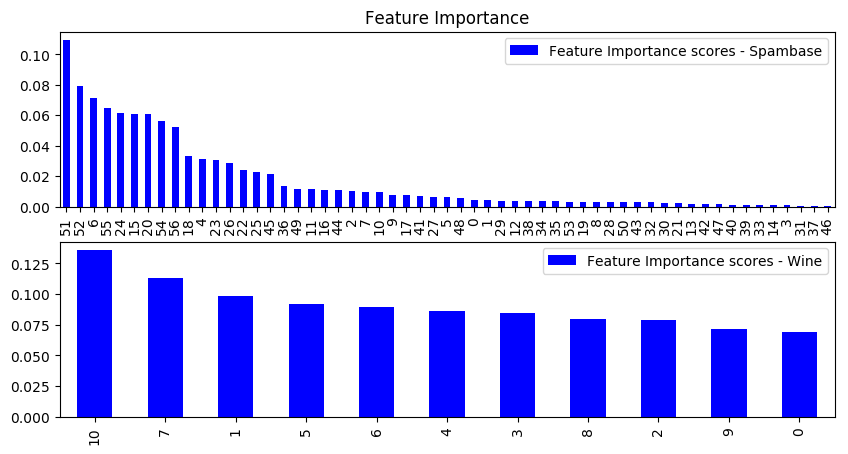

In [518]:
fig = plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
fs_spambase[0].plot(kind='bar', title='Feature Importance', label='Feature Importance scores - Spambase', color='b')
plt.legend()

plt.subplot(2,1,2)
fs_wine[0].plot(kind='bar',label='Feature Importance scores - Wine', color='b')
plt.legend()

plt.show()



### RF + ANN

In [522]:
from sklearn.base import TransformerMixin,BaseEstimator
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
         self.model = model
         self.n = n
    def fit(self, *args, **kwargs):
         self.model.fit(*args, **kwargs)
         return self
    def transform(self, X):
        return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]
        
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=7)
dims = range(1,57)
filtr = ImportanceSelect(rfc)
grid ={'filter__n':dims}
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('filter',filtr),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=False,cv=5)

gs.fit(X_train,Y_train)
rf_ann = pd.DataFrame(gs.cv_results_)
rf_ann_to_plot = rf_ann.groupby(['param_filter__n']).agg({'mean_train_score':'mean', 'mean_test_score':'mean'}).reset_index()


dims = range(1,12)
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=7)
filtr = ImportanceSelect(rfc)
grid ={'filter__n':dims}  
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('filter',filtr),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=False,cv=5)

gs.fit(X2_train,Y2_train)
rf_ann2 = pd.DataFrame(gs.cv_results_)
rf_ann_to_plot2 = rf_ann2.groupby(['param_filter__n']).agg({'mean_train_score':'mean', 'mean_test_score':'mean'}).reset_index()



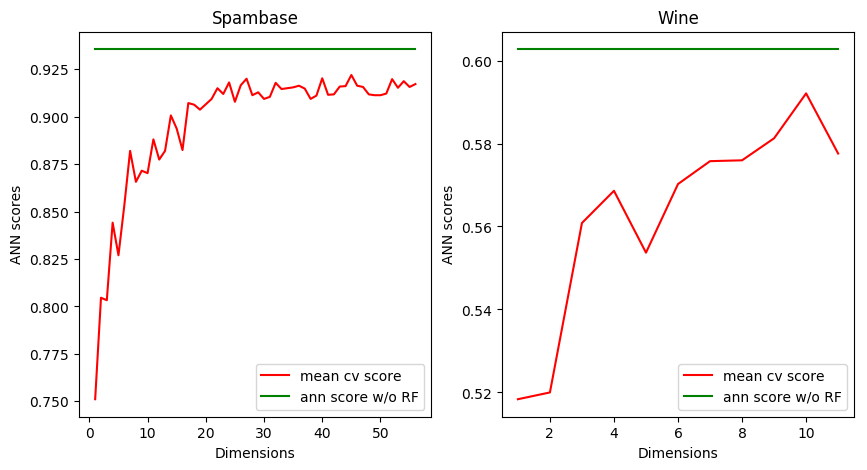

In [528]:
rf_ann_to_plot['orig_ann_score_spambase'] = orig_ann_score_spambase
rf_ann_to_plot2['orig_ann_score_wine'] = orig_ann_score_wine

fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(rf_ann_to_plot['param_filter__n'],  rf_ann_to_plot['mean_test_score'], label="mean cv score", color = 'r')
plt.plot(rf_ann_to_plot['param_filter__n'],  rf_ann_to_plot['orig_ann_score_spambase'], label="ann score w/o RF", color = 'g')
plt.title("Spambase")
plt.xlabel("Dimensions", fontsize=10), plt.ylabel('ANN scores', fontsize=10), plt.legend(loc="best",prop={'size':10})



plt.subplot(1,2,2)
plt.plot(rf_ann_to_plot2['param_filter__n'],  rf_ann_to_plot2['mean_test_score'], label="mean cv score", color = 'r')
plt.plot(rf_ann_to_plot2['param_filter__n'],  rf_ann_to_plot2['orig_ann_score_wine'], label="ann score w/o RF", color = 'g')
plt.title("Wine")
plt.xlabel("Dimensions", fontsize=10), plt.ylabel('ANN scores', fontsize=10), plt.legend(loc="best",prop={'size':10})

plt.show()

### RF + Clustering

In [593]:
tmp = pd.DataFrame(rf)
tmp.ix[:,51]

0      -0.145215
1      -0.145215
2      -0.145215
3      -0.145215
4      -0.145215
5      -0.145215
6      -0.145215
7      -0.145215
8      -0.145215
9      -0.145215
10     -0.145215
11     -0.145215
12     -0.145215
13     -0.145215
14     -0.145215
15     -0.145215
16     -0.145215
17     -0.145215
18     -0.145215
19     -0.145215
20     -0.145215
21     -0.145215
22     -0.145215
23     -0.145215
24     -0.145215
25     -0.145215
26     -0.145215
27     -0.145215
28     -0.145215
29     -0.145215
          ...   
4571   -0.145215
4572   -0.145215
4573   -0.145215
4574   -0.145215
4575   -0.145215
4576   -0.145215
4577   -0.145215
4578   -0.145215
4579   -0.145215
4580   -0.145215
4581   -0.145215
4582   -0.145215
4583   -0.145215
4584   -0.145215
4585   -0.145215
4586   -0.145215
4587   -0.145215
4588   -0.145215
4589   -0.145215
4590   -0.145215
4591   -0.145215
4592   -0.145215
4593   -0.145215
4594   -0.145215
4595   -0.145215
4596   -0.145215
4597   -0.145215
4598   -0.1452

# 

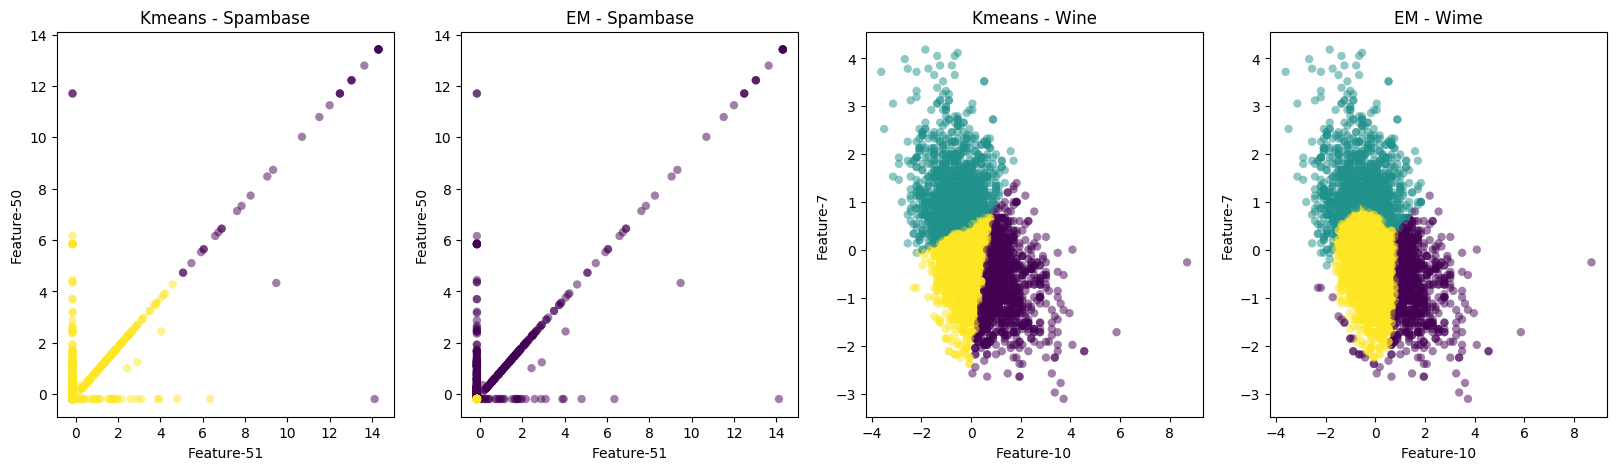

In [596]:
dim = 57
filtr = ImportanceSelect(rfc,dim)
projected = filtr.fit_transform(X_train,Y_train)
reshaped = (np.vstack((projected[:,51],projected[:,50])).T)

km = kmeans(random_state=5)
km.set_params(n_clusters=2)
km.fit(reshaped)


gmm = GMM(random_state=5)
gmm.set_params(n_components=2)
gmm.fit(reshaped)


# Dataset-2
dim = 11
filtr = ImportanceSelect(rfc,dim)
projected = filtr.fit_transform(X2_train,Y2_train)
reshaped2 = (np.vstack((projected[:,10],projected[:,7])).T)

km2 = kmeans(random_state=5)
km2.set_params(n_clusters=3)
km2.fit(reshaped2)


gmm2 = GMM(random_state=5)
gmm2.set_params(n_components=3)
gmm2.fit(reshaped2)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))

ax1.scatter(reshaped[:,0], 
             reshaped[:,1],
             c=km.predict(reshaped), 
             edgecolor='none', 
             alpha=0.5)    
ax1.set_xlabel('Feature-51')
ax1.set_ylabel('Feature-50')
ax1.set_title('Kmeans - Spambase')

ax2.scatter(reshaped[:,0], 
             reshaped[:,1],
             c=gmm.predict(reshaped), 
             edgecolor='none', 
             alpha=0.5)    
ax2.set_xlabel('Feature-51')
ax2.set_ylabel('Feature-50')
ax2.set_title('EM - Spambase')


ax3.scatter(reshaped2[:, 0], 
            reshaped2[:, 1],
            c=km2.predict(reshaped2),             
            edgecolor='none', 
            alpha=0.5)    
ax3.set_xlabel('Feature-10')
ax3.set_ylabel('Feature-7')
ax3.set_title('Kmeans - Wine')

ax4.scatter(reshaped2[:, 0], 
            reshaped2[:, 1],
            c=gmm2.predict(reshaped2),             
            edgecolor='none', 
            alpha=0.5)    
ax4.set_xlabel('Feature-10')
ax4.set_ylabel('Feature-7')
ax4.set_title('EM - Wime')


plt.show()


In [530]:
dim = 13
filtr = ImportanceSelect(rfc,dim)
projected = filtr.fit_transform(X_train,Y_train)
projected.shape


(4601, 13)

In [531]:
tmp = pd.DataFrame(projected)
tmp = tmp.sort_values(by=[0], ascending=False)

In [533]:
tmp = tmp.sort_values(by=[0], ascending=False)

In [534]:
tmp

,0,1,2,3,4,5,6,7,8,9,10,11,12
4463,39.491909,-0.308355,-0.291794,-0.252336,-0.328815,-0.301378,-0.674419,-0.111124,-0.459010,2.815262,-0.464314,-0.212994,-0.227895
4459,23.126928,-0.308355,-0.291794,-0.021413,-0.328815,-0.301378,-0.674419,0.254003,-0.379839,0.449449,-0.464314,-0.212994,-0.227895
4244,11.410156,-0.308355,-0.291794,-0.242073,-0.328815,-0.301378,-0.674419,-0.119918,-0.396333,0.624068,-0.464314,-0.212994,-0.227895
3963,9.887319,-0.308355,-0.291794,-0.252336,-0.328815,-0.301378,-0.674419,-0.100596,-0.454061,-0.936242,-0.464314,-0.212994,-0.227895
875,9.286522,-0.308355,-0.291794,-0.242073,-0.328815,-0.301378,-0.674419,-0.111124,-0.442516,1.508432,-0.464314,-0.212994,-0.227895
4464,9.119770,-0.308355,-0.291794,-0.190757,-0.328815,-0.301378,-0.674419,-0.056468,-0.383137,2.454757,-0.464314,-0.212994,-0.227895
1389,8.661202,-0.308355,-0.291794,-0.242073,-0.328815,-0.301378,-0.674419,-0.111124,-0.442516,1.508432,-0.464314,-0.212994,-0.227895
4246,7.501296,-0.308355,-0.291794,-0.247205,-0.328815,-0.301378,-0.674419,-0.127987,-0.353448,0.297361,0.071050,-0.212994,-0.227895
1288,6.955674,5.117601,-0.291794,0.009377,-0.328815,-0.301378,0.241729,0.020377,0.726907,1.209889,-0.018178,0.012950,-0.227895
1147,6.933604,5.101331,-0.291794,0.009377,-0.328815,-0.301378,0.233400,0.019179,0.728557,1.198623,0.115663,-0.009645,-0.227895
